In [1]:
suppressMessages(library(RSkittleBrewer))
suppressMessages(library(genefilter))
suppressMessages(library(devtools))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(ggplot2))
suppressMessages(library(DESeq2))
suppressMessages(library(calibrate))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))
suppressMessages(library(cluster))
suppressMessages(library(Biobase))
suppressMessages(library(qvalue))
suppressMessages(library(EBSeq))
suppressMessages(library(Rsamtools))
suppressMessages(library(GenomicFeatures))
suppressMessages(library(GenomicAlignments))
suppressMessages(library(BiocParallel))
suppressMessages(library(tximport))
suppressMessages(library(readr))
suppressMessages(library(tximportData))
suppressMessages(library(apeglm))
suppressMessages(library(knitr))
suppressMessages(library(BiocParallel))
suppressMessages(library(IHW))
suppressMessages(library(ashr))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(AnnotationDbi))
suppressMessages(library(ReportingTools))
suppressMessages(library(regionReport))
suppressMessages(library(Glimma))
suppressMessages(library(pcaExplorer))
suppressMessages(library(DEVis))
suppressMessages(library(vsn))
suppressMessages(library(repr))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(glmpca))
suppressMessages(library(Gviz))
suppressMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))
suppressMessages(library(ensembldb))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(tximeta))
suppressMessages(library(GenomicRanges))
suppressMessages(library(biovizBase))
suppressMessages(library(ggbio))
suppressMessages(library(karyoploteR))
suppressMessages(library(gplots))
suppressMessages(library(dplyr))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(PCAtools))
suppressMessages(library(sva))
suppressMessages(library(DRIMSeq))
suppressMessages(library(biomaRt))
suppressMessages(library(grid))
suppressMessages(library(PoiClaClu))

In [126]:
register(MulticoreParam(35))

In [124]:
# suppress warning messages
options(warn=-1)

In [125]:
# disable scientific notation
options(scipen=999)

# DESeq2

In [3]:
# function to store heatmaps as png
save_pheatmap_png <- function(x, filename, width=580, height=480) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   invisible(dev.off())
}

### Import GENES data from RSEM count files

In [32]:
setwd('/mnt/nfs/shared/999993-Bioda/projects/kaja_transposons/RNA_SEQ/KPSP_MIX1+2/')
getwd()

[1] "/mnt/nfs/shared/999993-Bioda/projects/kaja_transposons/RNA_SEQ/KPSP_MIX1+2"

In [ ]:
mat <- DESeqDataSetFromMatrix()

In [79]:
rsem_samples_genes <- read.table(file.path("RSEM_IN", "rsem_samples.txt"), header = FALSE)
files_genes <- file.path("RSEM_IN", paste0(rsem_samples_genes$V1, ".genes.results"))
names(files_genes) <- paste0("RNA", 1:16)
suppressMessages(txi.rsem_genes <- tximport(files_genes, 
                           type = "rsem", 
                           txIn = FALSE, 
                           txOut = FALSE,
                           countsFromAbundance= 'no'))
names(txi.rsem_genes)

[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

In [80]:
# replace all 0 by 1 to be compatible with tx import
txi.rsem_genes$counts[txi.rsem_genes$counts == 0] <- 1
txi.rsem_genes$abundance[txi.rsem_genes$abundance == 0.00] <- 1.00
txi.rsem_genes$length[txi.rsem_genes$length == 0.00] <- 1.00
head(txi.rsem_genes$counts, 2)

RNA1 RNA2 RNA3 RNA4 RNA5 RNA6 RNA7 RNA8 RNA9 RNA10 RNA11
ENSG00000000003.15 1    1    1    1    1    1    1    1    1    1     1    
ENSG00000000005.6  1    1    1    1    1    1    1    1    1    1     1    
                   RNA12 RNA13 RNA14 RNA15 RNA16
ENSG00000000003.15 1     1     1     1     1    
ENSG00000000005.6  1     1     1     1     1

In [81]:
# design = table of samples corresponding to conditions
condition = factor(rep(c('C','T'), each = 8))
samples <- data.frame(row.names=c("RS01","RS02","RS03","RS04","RS05","RS06","RS07","RS08",
                                 "RS09","RS10","RS11","RS12","RS13","RS14","RS15","RS16"),
                      condition=as.factor(c(rep("C",8), rep("T",8))))
# importing GENES data into DESeq
suppressMessages(dds_rsem <- DESeqDataSetFromTximport(txi.rsem_genes, samples, ~condition))
# Filter null or ultra-low abundance GENES
keep <- rowSums(counts(dds_rsem)) > 16
dds_rsem <- dds_rsem[keep,]
dds_rsem

class: DESeqDataSet 
dim: 26304 16 
metadata(1): version
assays(2): counts avgTxLength
rownames(26304): ENSG00000000419.12 ENSG00000000457.14 ...
  ENSG00000288473.1 ENSG00000288520.1
rowData names(0):
colnames(16): RS01 RS02 ... RS15 RS16
colData names(1): condition

In [83]:
# remove the decimal
ga_list = rownames(dds_rsem)
for (i in 1:length(id_list)) {
  ga_list[i] <- vapply(strsplit(ga_list[i], ".", fixed = TRUE), "[", "", 1)
}
rownames(dds_rsem) <- ga_list
# remove duplicates
dds_rsem <- dds_rsem[!duplicated(rownames(dds_rsem)),]
ga_list = rownames(dds_rsem)

In [84]:
# create a dataframe from both lists and export for Python processing with Pyensembl
tx_df = data.frame("GENE_ID" = ga_list, stringsAsFactors = FALSE)
write.table(tx_df, 
            file = "RSEM_TEMP/rsem_geneID_dds.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)

In [85]:
# back from Python
# structurue: ['GENE_ID', 'GENE_NAME']
ga_df <- read.table(file="RSEM_TEMP/rsem_geneID_dds_OK.txt", 
                        sep="\t", 
                        header=T, 
                        stringsAsFactors=F)

In [86]:
# check if rownames and processed dataframe length match
length(ga_df$GENE_ID) == length(rownames(dds_rsem))

[1] TRUE

In [87]:
# duplicate dataset and rename rownames with GENE_NAME
dds_rsem_names <- dds_rsem
rownames(dds_rsem_names) <- ga_df$GENE_NAME
dds_rsem_names

class: DESeqDataSet 
dim: 26279 16 
metadata(1): version
assays(2): counts avgTxLength
rownames(26279): DPM1 SCYL3 ... AL669830.1 AL357075.5
rowData names(0):
colnames(16): RS01 RS02 ... RS15 RS16
colData names(1): condition

In [88]:
# run DSEq on GENES with genes accession numbers
suppressMessages(dds_rsem <- DESeq2::DESeq(dds_rsem))

In [89]:
# run DSEq on GENES with genes symbols
suppressMessages(dds_rsem_names <- DESeq2::DESeq(dds_rsem_names))

In [147]:
# add gene_id and gene_name columns ta dataset with rownames as GENE_NAME, reorder column names
mcols(dds_rsem_names)$gene_id <- ga_df$GENE_ID
mcols(dds_rsem_names)$gene_name <- ga_df$GENE_NAME
orderCol <- c('gene_id', 'gene_name', 'baseMean', 'baseVar', 'allZero', 'dispGeneEst', 'dispGeneIter', 
              'dispFit', 'dispersion', 'dispIter', 'dispOutlier', 'dispMAP', 'Intercept', 
              'condition_T_vs_C', 'SE_Intercept', 'SE_condition_T_vs_C', 'WaldStatistic_Intercept', 
              'WaldStatistic_condition_T_vs_C', 'WaldPvalue_Intercept', 'WaldPvalue_condition_T_vs_C', 
              'betaConv', 'betaIter', 'deviance', 'maxCooks', 'replace')
invisible(mcols(dds_rsem_names) <- mcols(dds_rsem_names)[, orderCol])
colnames(mcols(dds_rsem_names))

[1] "gene_id"                        "gene_name"                     
 [3] "baseMean"                       "baseVar"                       
 [5] "allZero"                        "dispGeneEst"                   
 [7] "dispGeneIter"                   "dispFit"                       
 [9] "dispersion"                     "dispIter"                      
[11] "dispOutlier"                    "dispMAP"                       
[13] "Intercept"                      "condition_T_vs_C"              
[15] "SE_Intercept"                   "SE_condition_T_vs_C"           
[17] "WaldStatistic_Intercept"        "WaldStatistic_condition_T_vs_C"
[19] "WaldPvalue_Intercept"           "WaldPvalue_condition_T_vs_C"   
[21] "betaConv"                       "betaIter"                      
[23] "deviance"                       "maxCooks"                      
[25] "replace"

## Exploratory analysis and visualization

In [92]:
colnames(mcols(dds_rsem_names))

[1] "baseMean"                       "baseVar"                       
 [3] "allZero"                        "dispGeneEst"                   
 [5] "dispGeneIter"                   "dispFit"                       
 [7] "dispersion"                     "dispIter"                      
 [9] "dispOutlier"                    "dispMAP"                       
[11] "Intercept"                      "condition_T_vs_C"              
[13] "SE_Intercept"                   "SE_condition_T_vs_C"           
[15] "WaldStatistic_Intercept"        "WaldStatistic_condition_T_vs_C"
[17] "WaldPvalue_Intercept"           "WaldPvalue_condition_T_vs_C"   
[19] "betaConv"                       "betaIter"                      
[21] "deviance"                       "maxCooks"                      
[23] "replace"

In [93]:
# shifted logarithm transformation (NTD)
ntd <- normTransform(dds_rsem_names)

In [94]:
# variance stabilizing transformation (VST) 
# for negative binomial data with a dispersion-mean trend
vsd <- vst(dds_rsem_names, blind = FALSE)

In [95]:
# regularized-logarithm transformation (RLOG)
rld <- rlog(dds_rsem_names, blind = FALSE)

In [140]:
# Plots showing standard deviation of the transformed data, across samples, against the mean

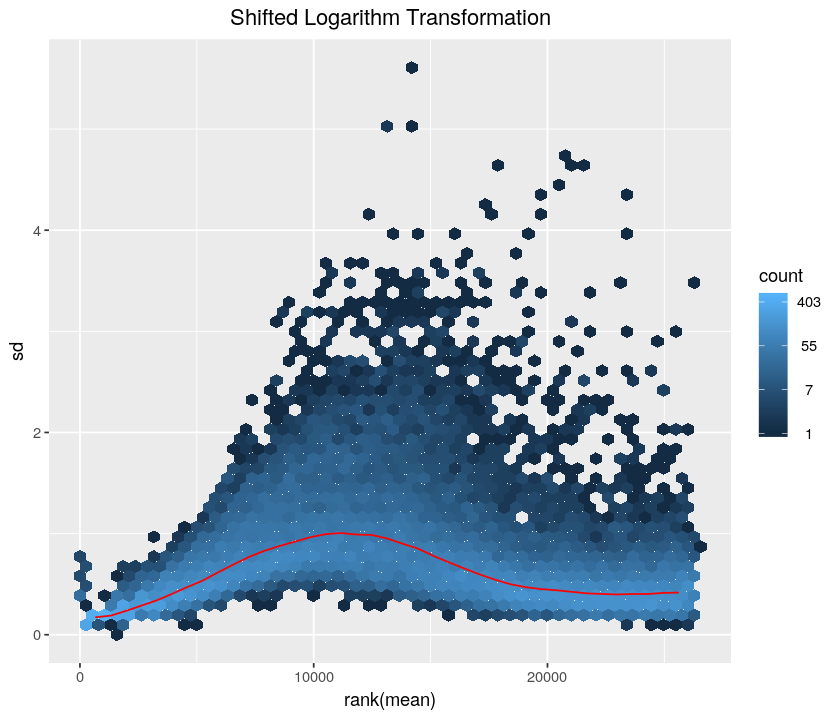

In [96]:
# shifted logarithm transformation (NTD)
options(repr.plot.width=7, repr.plot.height=6)
msd <- meanSdPlot(assay(ntd), plot=FALSE)
msd$gg +
ggtitle("Shifted Logarithm Transformation") +
theme(plot.title = element_text(hjust = 0.5))
ggsave("DESEQ2_RES/star_rsem_varTrans_NTD.png", width=7, height=6)
invisible(dev.off())

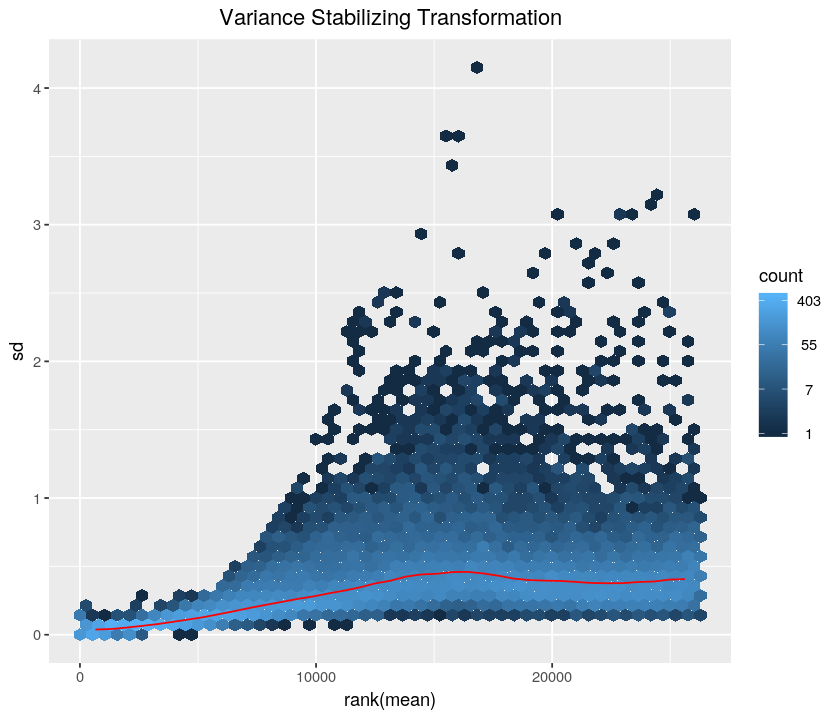

In [97]:
# variance stabilizing transformation (VSD)
options(repr.plot.width=7, repr.plot.height=6)
msd <- meanSdPlot(assay(vsd), plot=FALSE)
msd$gg +
ggtitle("Variance Stabilizing Transformation") +
theme(plot.title = element_text(hjust = 0.5))
ggsave("DESEQ2_RES/star_rsem_varTrans_VSD.png", width=7, height=6)
invisible(dev.off())

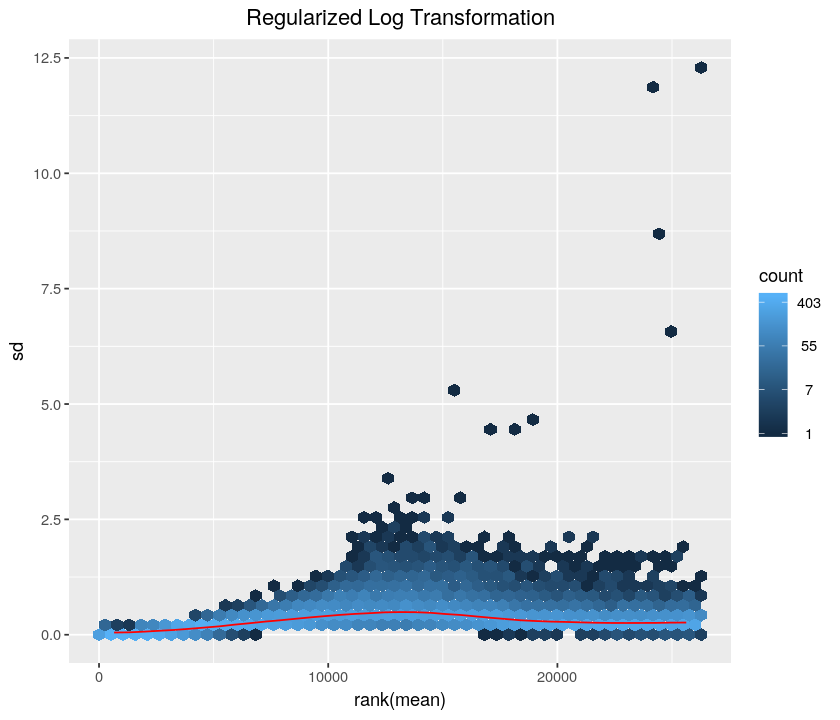

In [98]:
# regularized log transformation (RLD)
options(repr.plot.width=7, repr.plot.height=6)
msd <- meanSdPlot(assay(rld), plot=FALSE)
msd$gg +
ggtitle("Regularized Log Transformation") +
theme(plot.title = element_text(hjust = 0.5))
ggsave("DESEQ2_RES/star_rsem_varTrans_RLD.png", width=7, height=6)
invisible(dev.off())

In [41]:
# estimate size factors to account for sequencing depth
#dds_rsem_names <- estimateSizeFactors(dds_rsem_names)
#dds_rsem_names <- estimateDispersions(dds_rsem_names)
#dds_rsem_names <- nbinomWaldTest(dds_rsem_names)

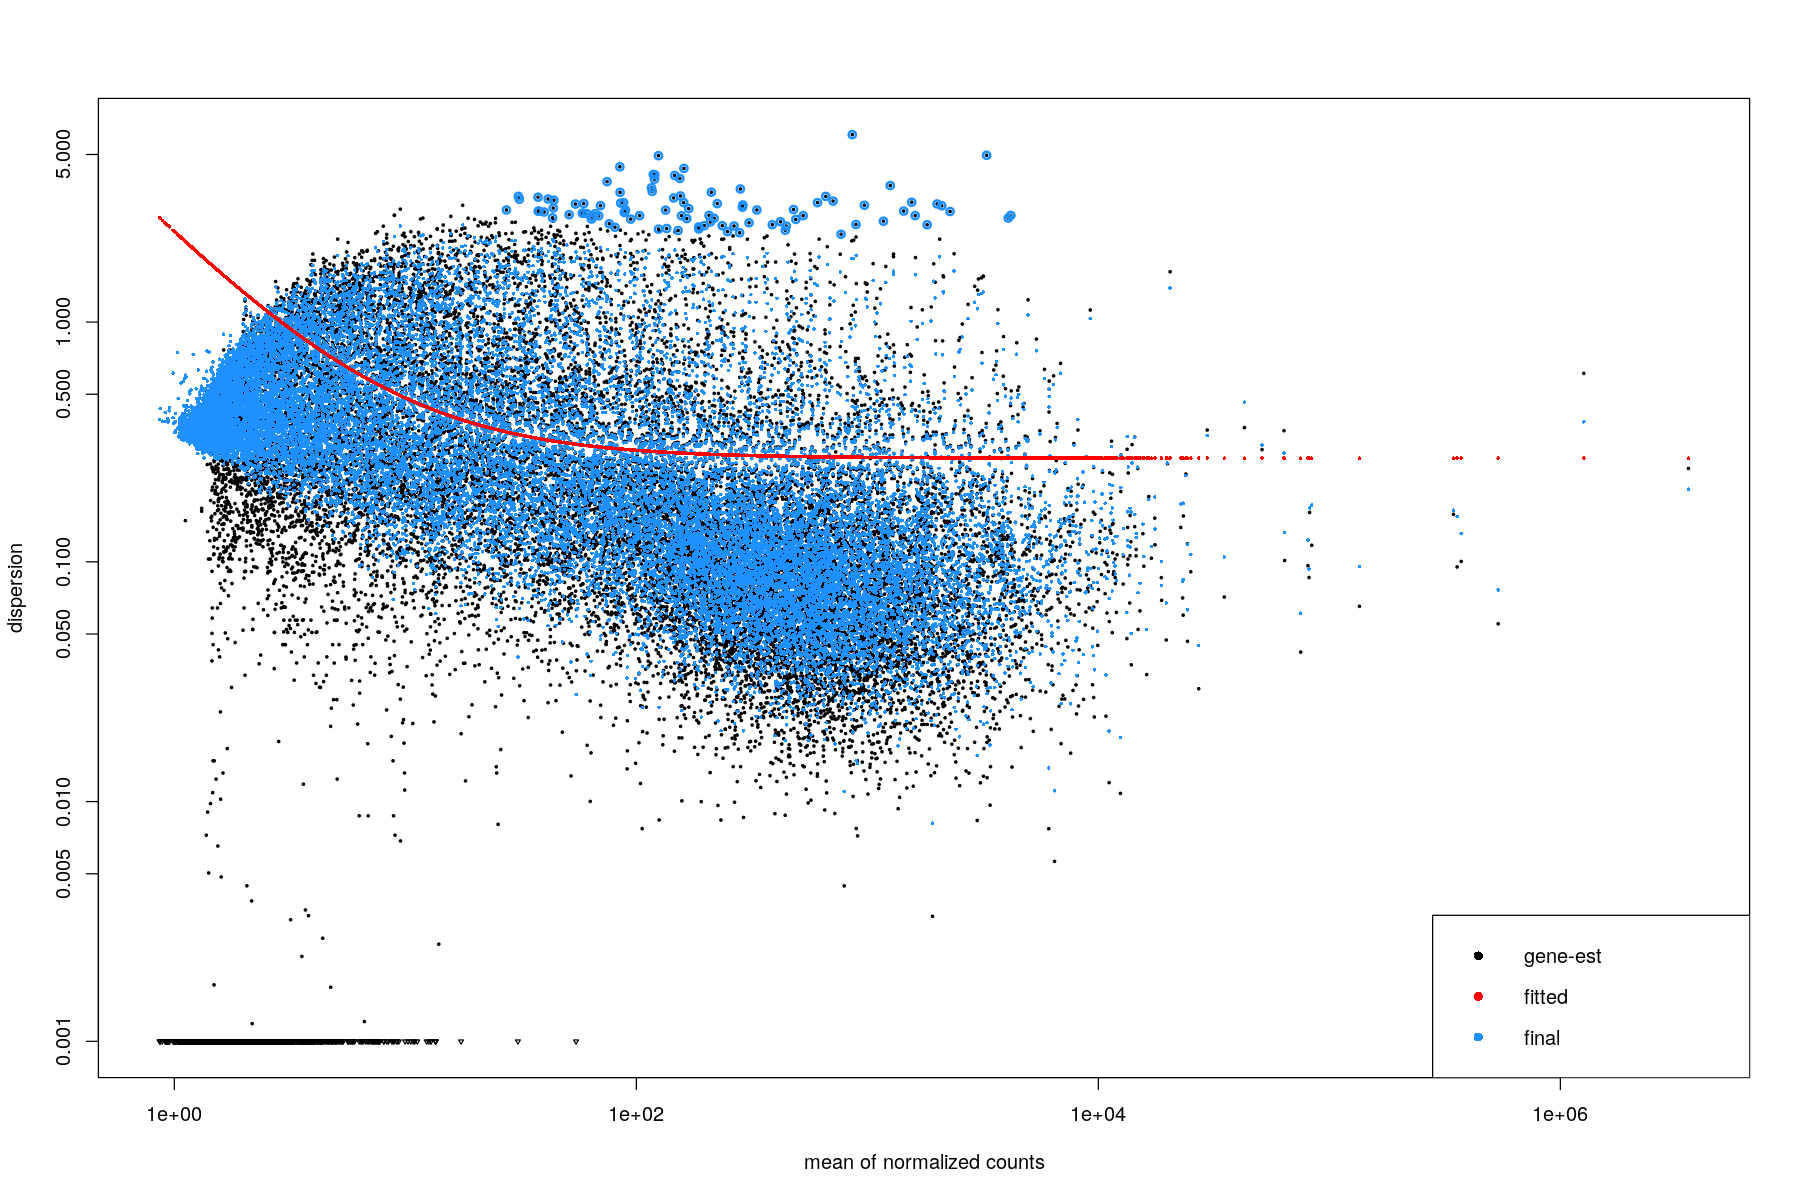

In [99]:
# gene-wise MLEs are obtained using only the respective gene’s data (black dots)
# a curve (red) is fit to the MLEs to capture the overall trend of dispersion-mean dependence
# shrinkage of the noisy gene-wise estimates toward the consensus (red line)
# black points circled in blue are detected as dispersion outliers
# https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
options(repr.plot.width=15, repr.plot.height=10)
plotDispEsts(dds_rsem_names, ymin=0.001, cex=0.4)
invisible(dev.print(png, "DESEQ2_RES/star_rsem_outliers_disp.png", width=640, height=480))

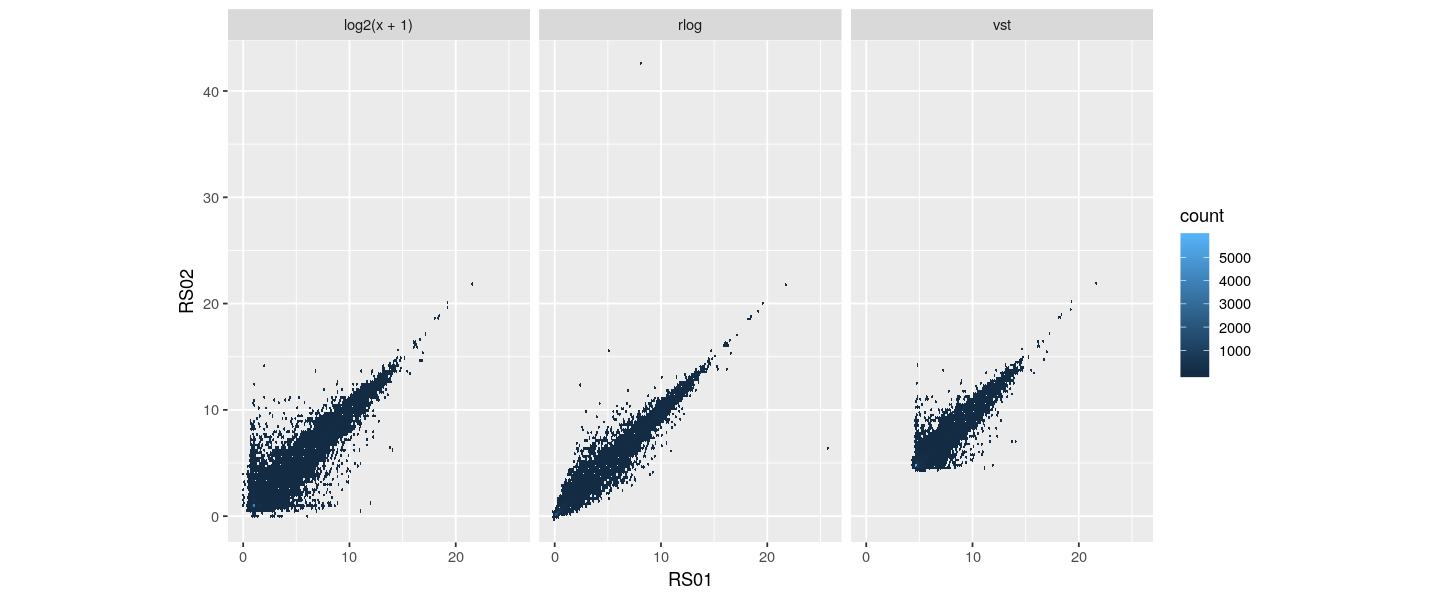

In [100]:
# Compare 2 samples expression after normalization
# scatterplots using the log2 transform of normalized counts (left)
# using the VST (middle), and using the rlog (right)
#png("DESEQ2_RES/salmon_2samples_comp.png")
df <- bind_rows(as_tibble(log2(counts(dds_rsem_names, 
                                          normalized=TRUE)[, 1:2]+1)) %>% mutate(transformation = "log2(x + 1)"),
                as_tibble(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"),
                as_tibble(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
options(repr.plot.width=12, repr.plot.height=5)
ggplot(df, aes(x = RS01, y = RS02)) + 
geom_hex(bins = 150) + 
coord_fixed() + 
facet_grid( . ~ transformation)
ggsave("DESEQ2_RES/star_rsem_2samples_comp.png", width=12, height=5)
invisible(dev.off())

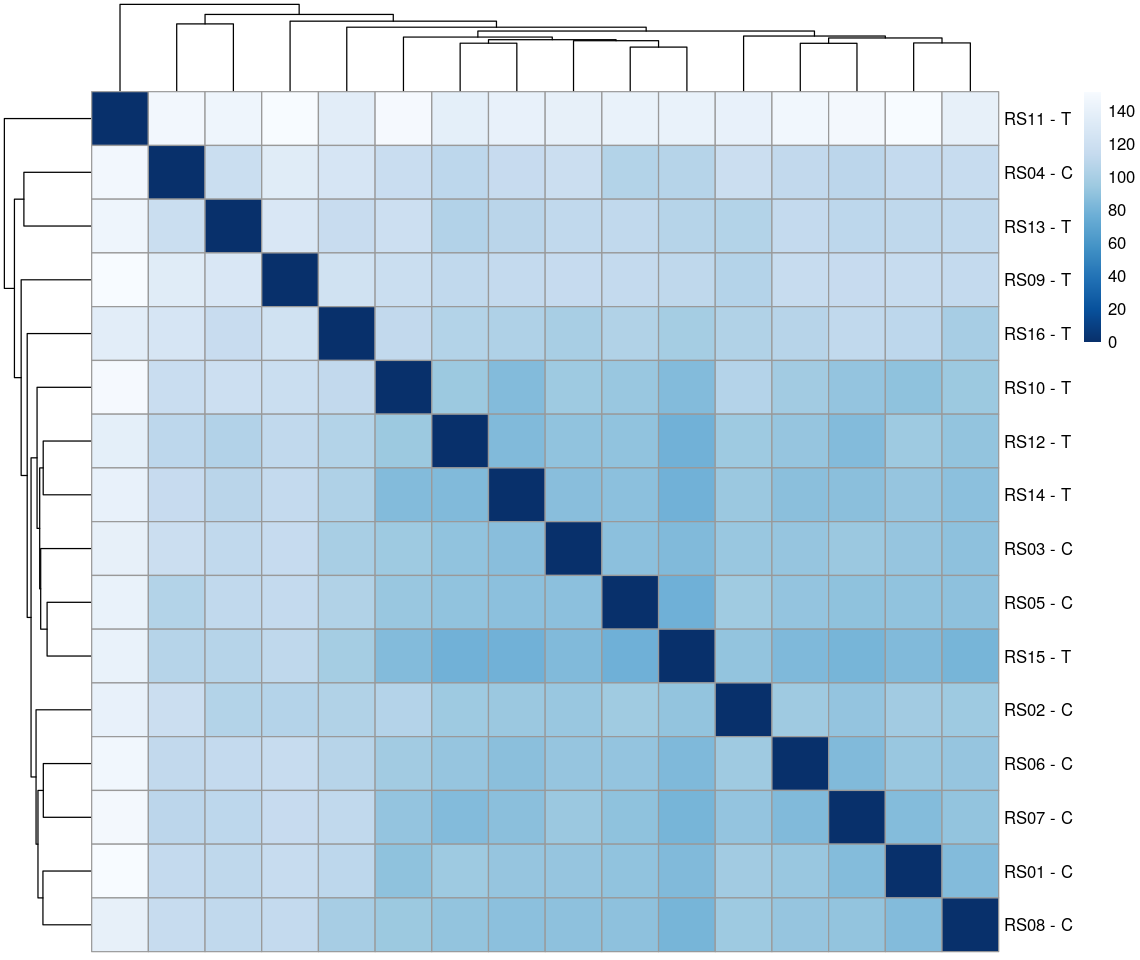

In [101]:
# assess overall similarity between samples
# Heatmap of sample-to-sample distances using the variance stabilizing transformed values
# dendrogram at the side shows the hierarchical clustering of the samples
sampleDists <- dist(t(assay(vsd)))
options(repr.plot.width=9.5, repr.plot.height=8)
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(colnames(vsd), vsd$condition, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)
pm = pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)
save_pheatmap_png(pm, "DESEQ2_RES/star_rsem_heatmap_sample_dist.png")

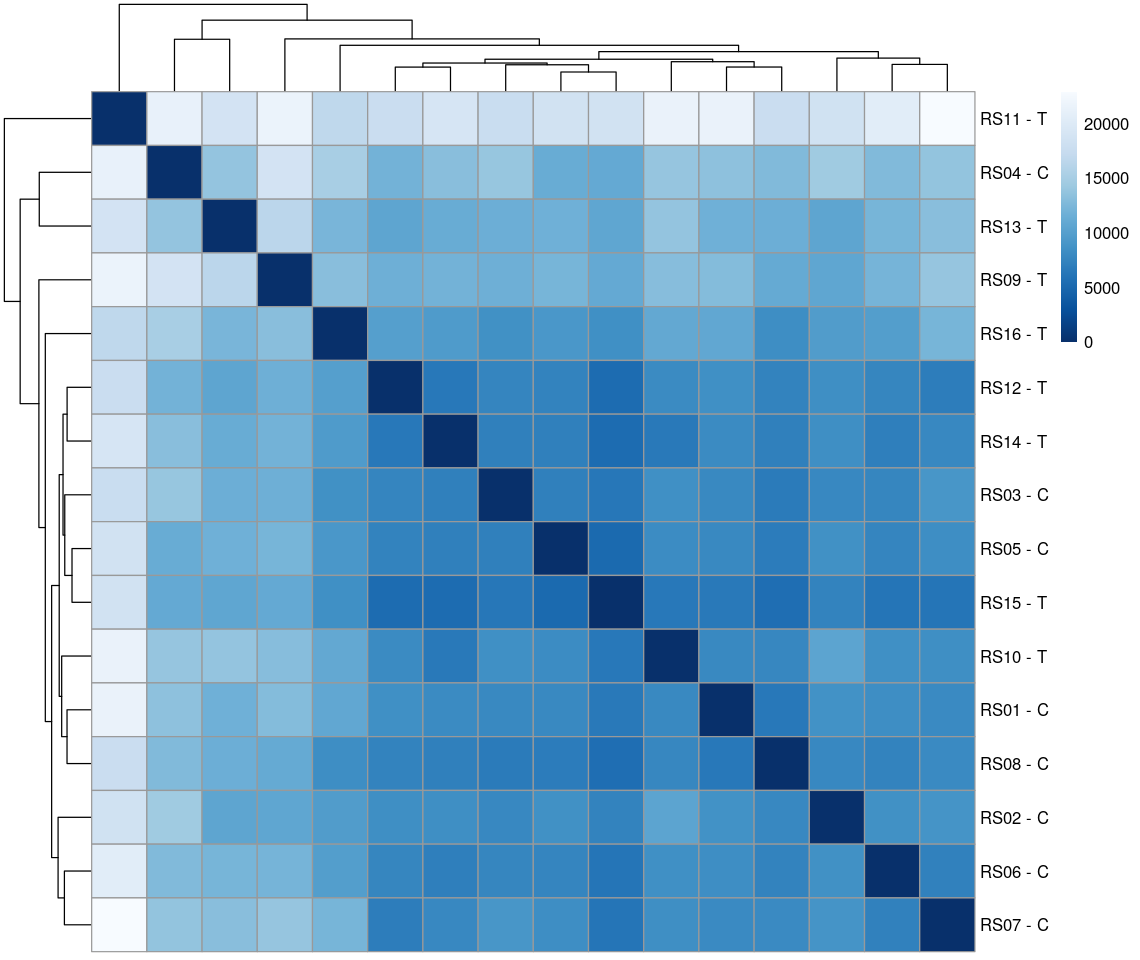

In [102]:
# calculating sample distances using the Poisson Distance
poisd <- PoissonDistance(t(counts(dds_rsem_names)))
options(repr.plot.width=9.5, repr.plot.height=8)
samplePoisDistMatrix <- as.matrix(poisd$dd)
rownames(samplePoisDistMatrix) <- paste(colnames(dds_rsem_names), dds_rsem_names$condition, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pm = pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)
save_pheatmap_png(pm, "DESEQ2_RES/star_rsem_heatmap_sample_dist_poisson.png")

### PCA Plot

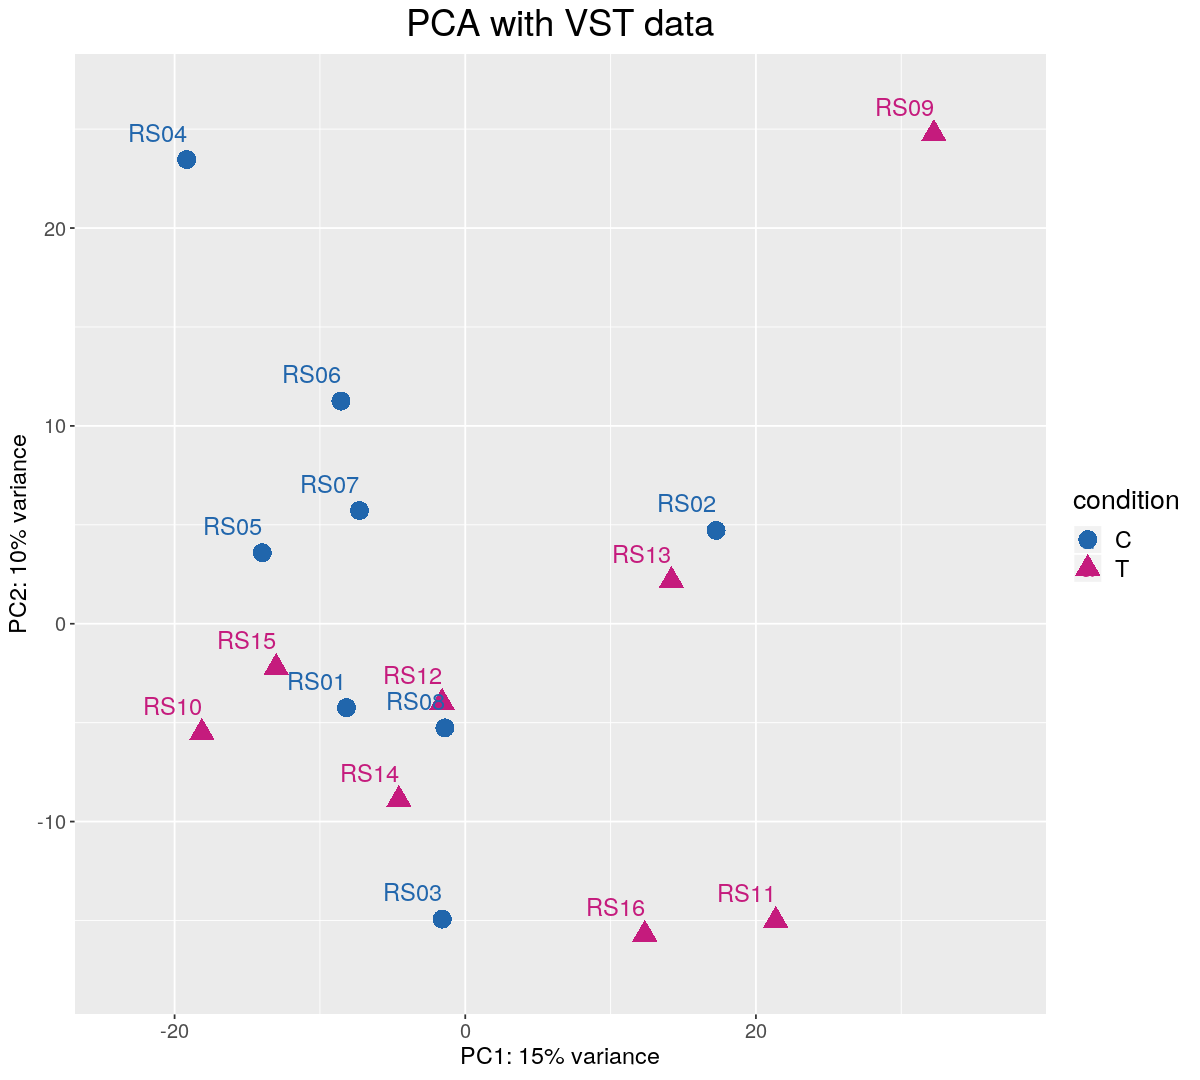

In [103]:
# PCA plot using the VST data
pcaData <- DESeq2::plotPCA(vsd, intgroup = colnames(colData(vsd)[1]), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with VST data") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/star_rsem_PCA_VST_samples.png", width=10, height=9)
invisible(dev.off())

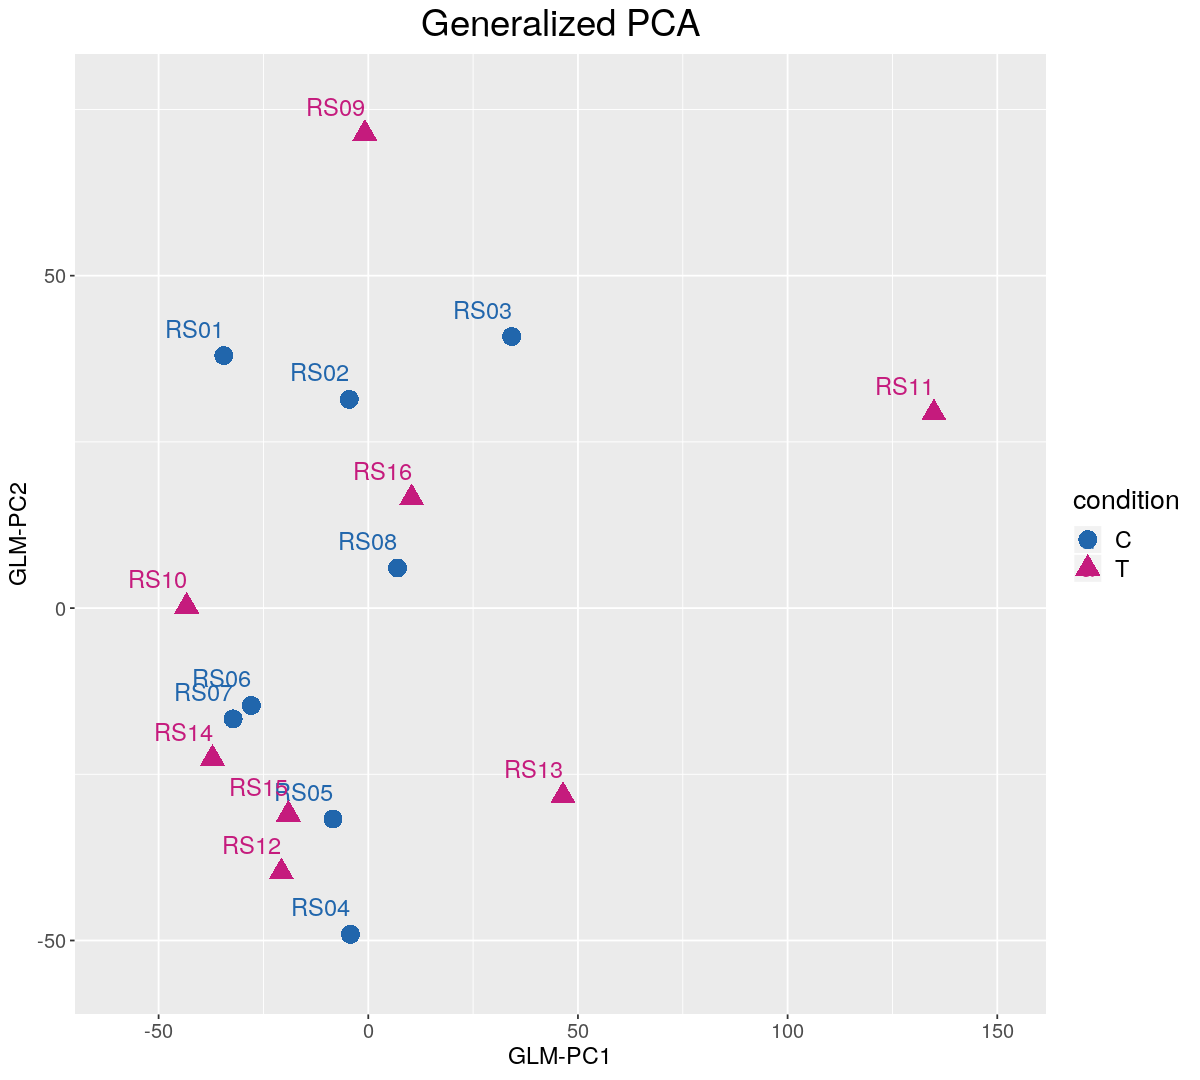

In [104]:
# MUST BE DONE WITH ACCESSION NUMBERS
# generalized principal component analysis (GLM-PCA)
# --> generalization of PCA to exponential family likelihoods
gpca <- glmpca(counts(dds_rsem), L=2)
gpca.dat <- gpca$factors
gpca.dat$samples <- colnames(dds_rsem)
gpca.dat$condition <- as.vector(dds_rsem$condition)
options(repr.plot.width=10, repr.plot.height=9)
ggplot(gpca.dat, aes(x = dim1, y = dim2,  color=condition, shape=condition)) +
geom_text(aes(label=samples),hjust=1, vjust=-1, cex=5, na.rm=TRUE) +
geom_point(size=5, na.rm=TRUE) + 
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
xlab("GLM-PC1") +
ylab("GLM-PC2") +
ggtitle("Generalized PCA") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/star_rsem_GLM-PCA.png", width=10, height=9)
invisible(dev.off())

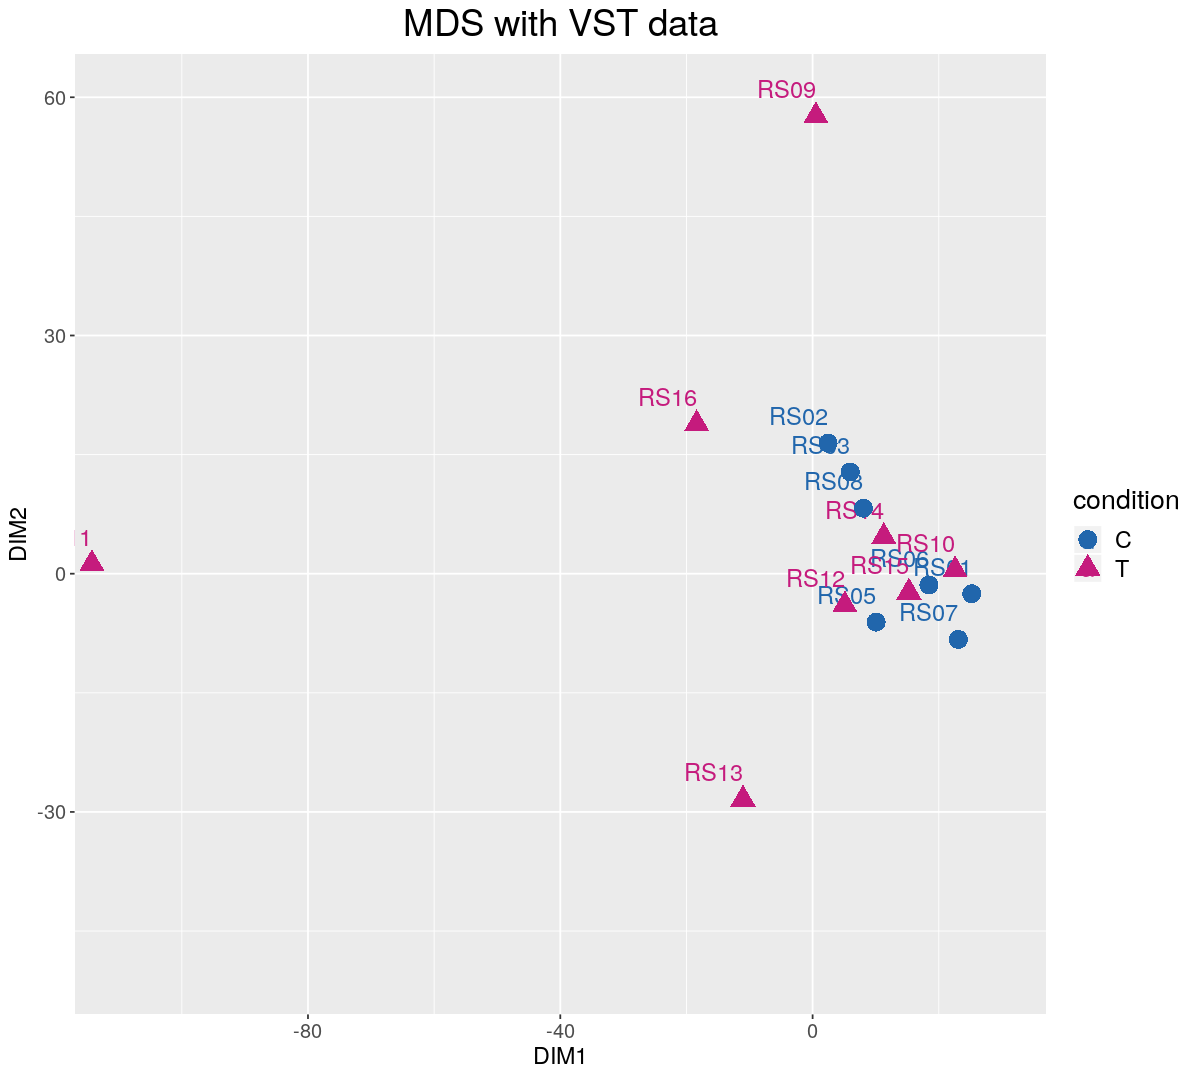

In [105]:
# multidimensional scaling (MDS) plot
options(repr.plot.width=10, repr.plot.height=9)
mds <- as.data.frame(colData(vsd)) %>% cbind(cmdscale(sampleDistMatrix))
mds$samples <- colnames(dds_rsem_names)
ggplot(mds, aes(x = `1`, y = `2`, color = condition, shape = condition)) +
geom_text(aes(label=samples),hjust=1, vjust=-1, cex=5, na.rm=TRUE) +
geom_point(size=5, na.rm=TRUE) +
xlab("DIM1") +
ylab("DIM2") +
xlim(-110, 30) + 
ylim(-50, 60) + 
ggtitle("MDS with VST data") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/star_rsem_MDS_VST.png", width=10, height=9)
invisible(dev.off())

## Differential Expression Analysis

In [106]:
# lists the coefficients
resultsNames(dds_rsem_names)

[1] "Intercept"        "condition_T_vs_C"

In [107]:
# results with genes symbols
res_rsem_names <- DESeq2::results(dds_rsem_names, name="condition_T_vs_C")

In [108]:
# results with accession numbers
res_rsem <- DESeq2::results(dds_rsem, name="condition_T_vs_C")

In [109]:
summary(res_rsem_names)
summary <- capture.output(summary(res_rsem_names))
fileConn<-file("DESEQ2_RES/star_rsem_resultsSummary.txt")
write(summary, fileConn)
close(fileConn)


out of 26279 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 98, 0.37%
LFC < 0 (down)     : 36, 0.14%
outliers [1]       : 0, 0%
low counts [2]     : 8152, 31%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [110]:
# check which variables and tests were used in results
mcols(res_rsem_names)$description

[1] "mean of normalized counts for all samples"
[2] "log2 fold change (MLE): condition T vs C" 
[3] "standard error: condition T vs C"         
[4] "Wald statistic: condition T vs C"         
[5] "Wald test p-value: condition T vs C"      
[6] "BH adjusted p-values"

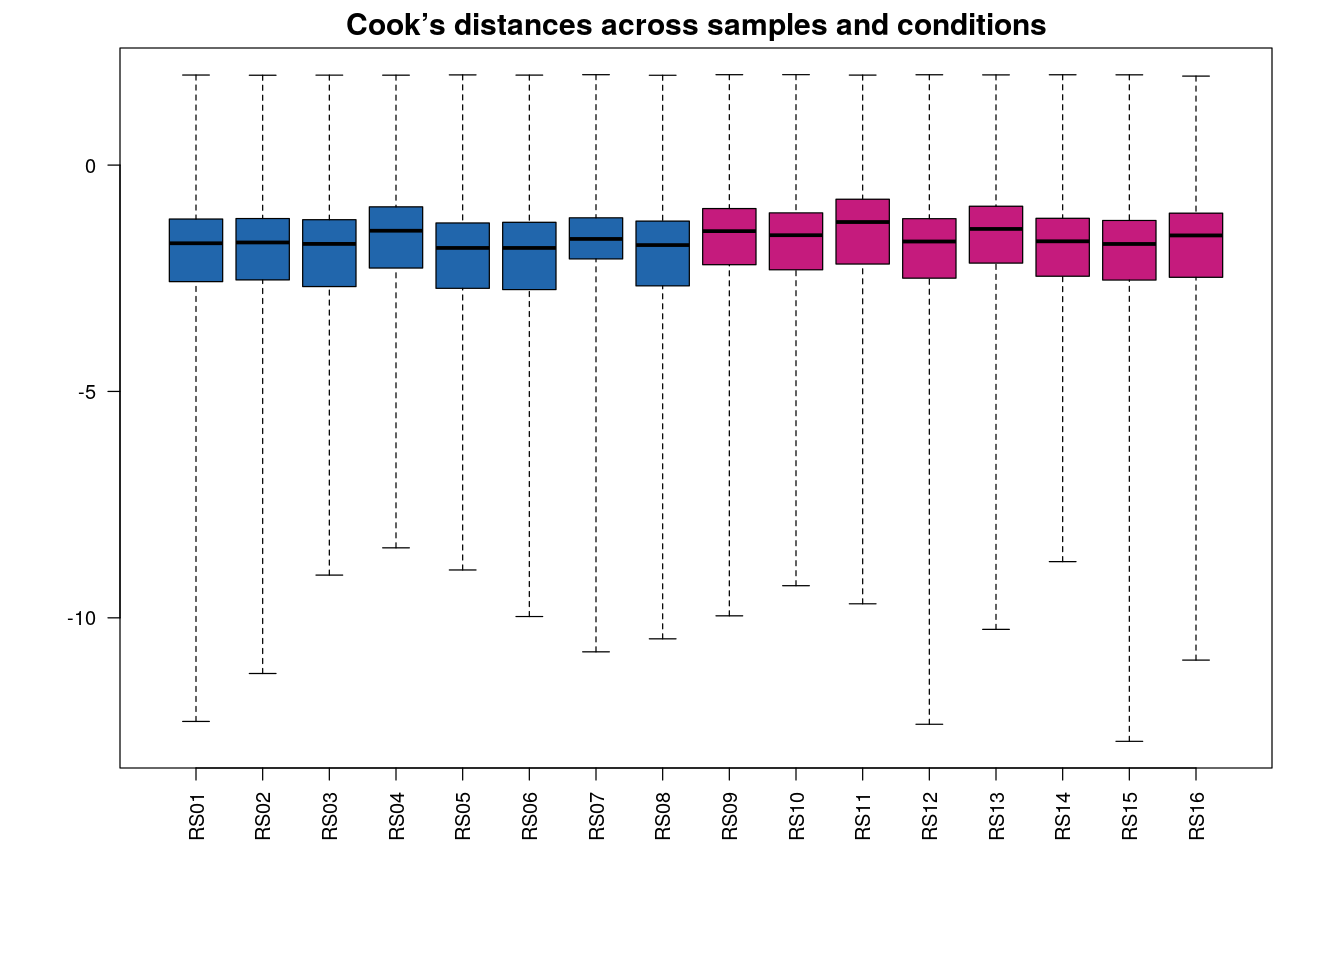

In [111]:
# boxplot of the Cook’s distances to see if one sample is consistently higher than others
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=11, repr.plot.height=8)
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds_rsem_names)[["cooks"]]), 
        range=0, 
        las=2, 
        col=col,
        main="Cook’s distances across samples and conditions",
        cex.main=1.5)
invisible(dev.print(png, "DESEQ2_RES/star_rsem_cook_boxplot.png", width=640, height=480))

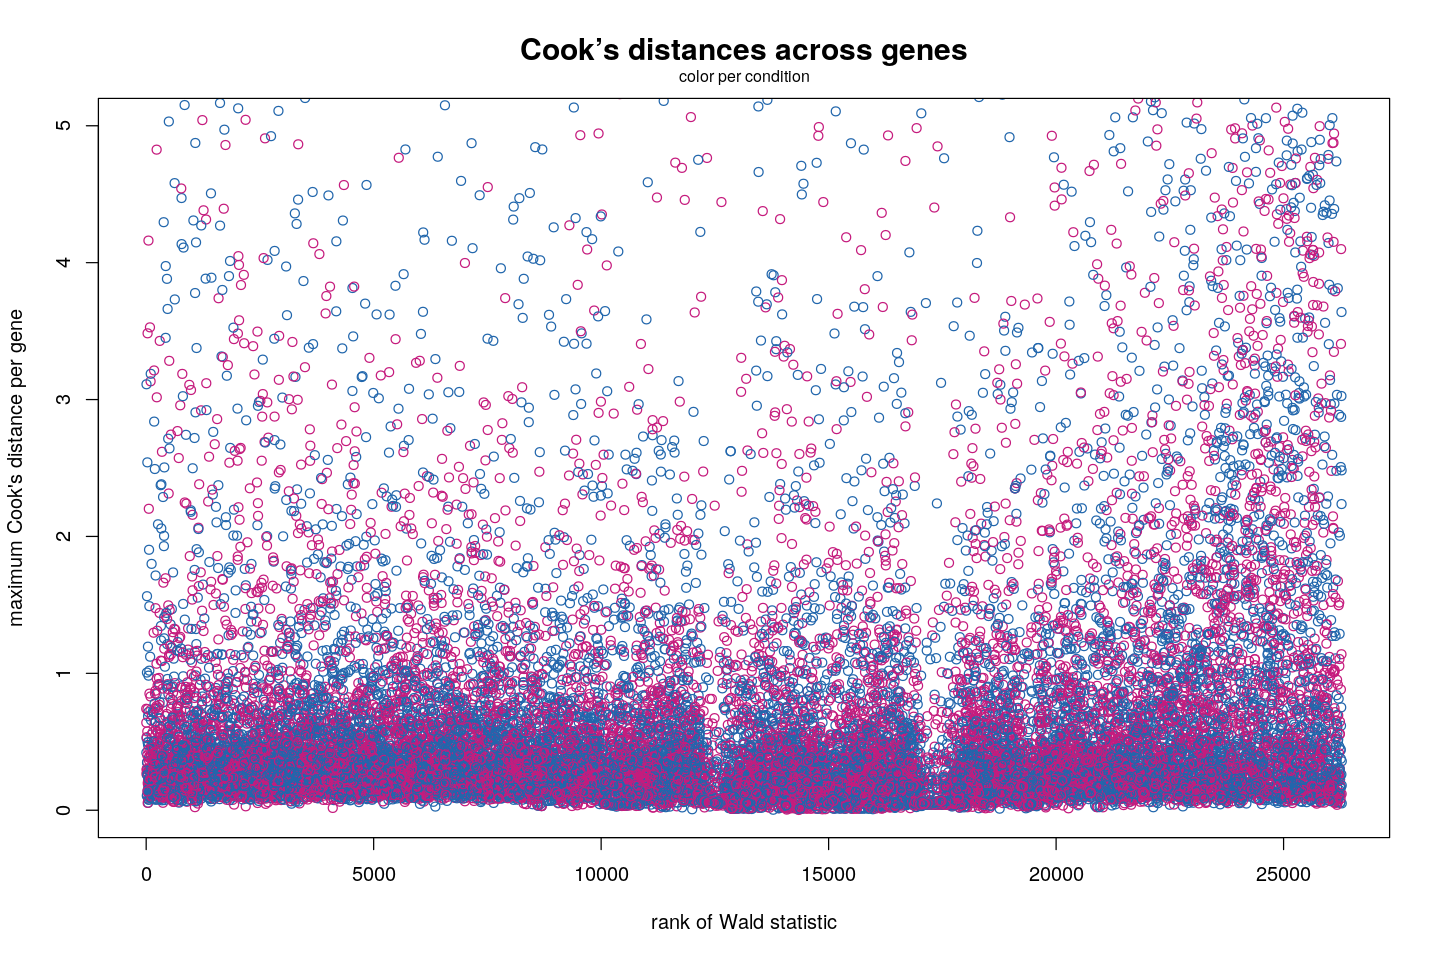

In [112]:
# Count outlier detection
# plot the maximum value of Cook’s distance for each row over the rank 
# of the test statistic to justify its use as a filtering criterion
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=12, repr.plot.height=8)
W <- res_rsem_names$stat
maxCooks <- apply(assays(dds_rsem_names)[["cooks"]],1,max)
idx <- !is.na(W)
plot(rank(W[idx]), 
     maxCooks[idx], 
     xlab="rank of Wald statistic", 
     ylab="maximum Cook's distance per gene",
     ylim=c(0,5), 
     cex=1, 
     col=col,
     main="Cook’s distances across genes",
     cex.main=1.5)
m <- ncol(dds_rsem_names)
p <- 3
abline(h=qf(.99, p, m - p))
subtitle ="color per condition"
mtext(line=0.5, adj=0.5, cex=0.8, subtitle)
invisible(dev.print(png, "DESEQ2_RES/star_rsem_cook_dist.png", width=640, height=480))

In [113]:
# Genes with adjusted p-values less than 0.1
# padj: Benjamini-Hochberg (BH) adjustment
# if we consider a fraction of 10% false positives acceptable
# we can consider all genes with an adjusted p value below 10% (= 0.1) as significant
table(res_rsem_names$padj < 0.1)


FALSE  TRUE 
17993   134 

In [114]:
# subset the results table to these genes and then sort it by the log2 fold change estimate 
resSig <- subset(res_rsem_names, padj < 0.1)

In [117]:
# top DE genes
rownames(head(resSig[ order(resSig$pvalue), decreasing = FALSE]))

Warning message in resSig[order(resSig$pvalue), decreasing = FALSE]:
"parameters in '...' not supported"


[1] "MTMR11"     "GNAZ"       "AL845472.2" "CNTNAP1"    "PNMA2"     
[6] "AICDA"

In [115]:
# significant genes with the strongest down-regulation
rownames(head(resSig[ order(resSig$log2FoldChange), ]))

[1] "IGHV3-48" "TSHZ2"    "IGHV3-21" "RNF175"   "RCAN2"    "TSPYL5"

In [185]:
# the most strongly up-regulated genes
rownames(head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ]))

[1] "ANKRD36BP2" "BTNL9"      "MTMR11"     "RASSF6"     "IL18RAP"   
[6] "PTCH1"

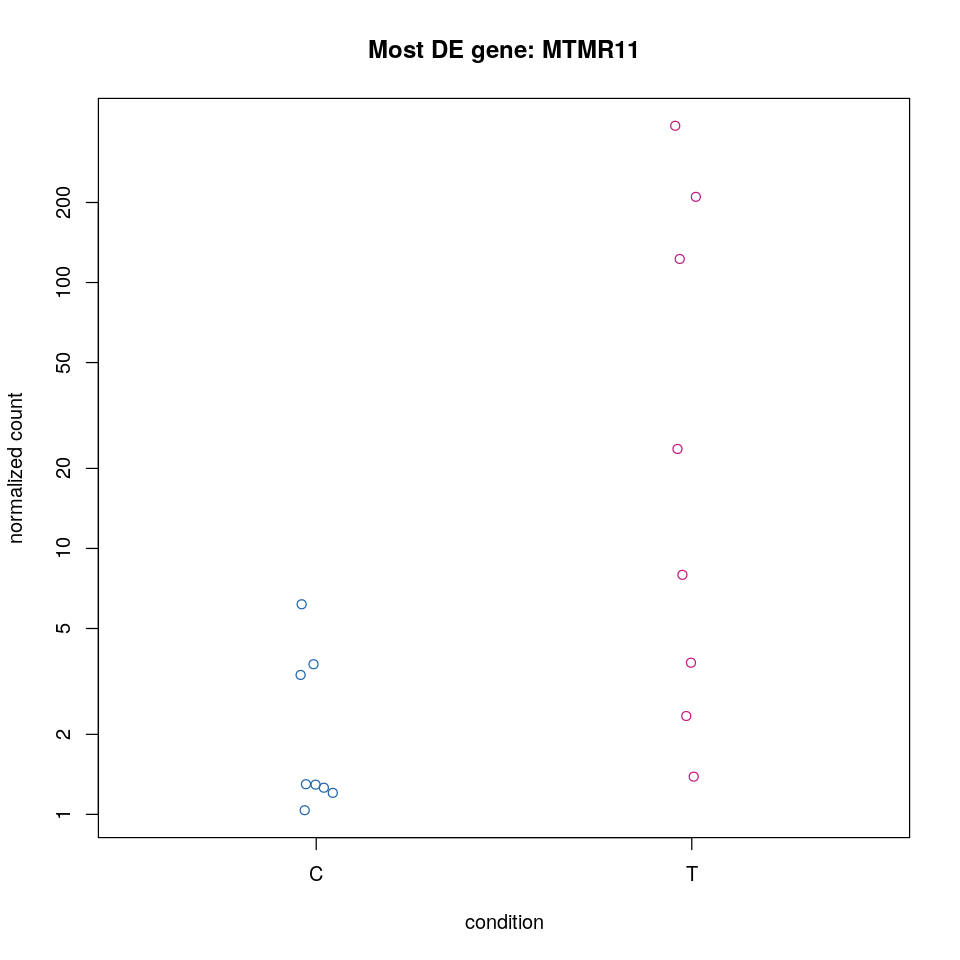

In [118]:
# retrieve the gene that has the lowest adjusted p value (= max differential expression)
# examine the counts of reads for this gene across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
topGene <- rownames(dds_rsem_names)[which.min(res_rsem_names$padj)]
plotCounts(dds_rsem_names, 
           gene = topGene, 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Most DE gene: ", topGene),
           xlab="condition")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_topDEGene_counts.png", width=480, height=480))

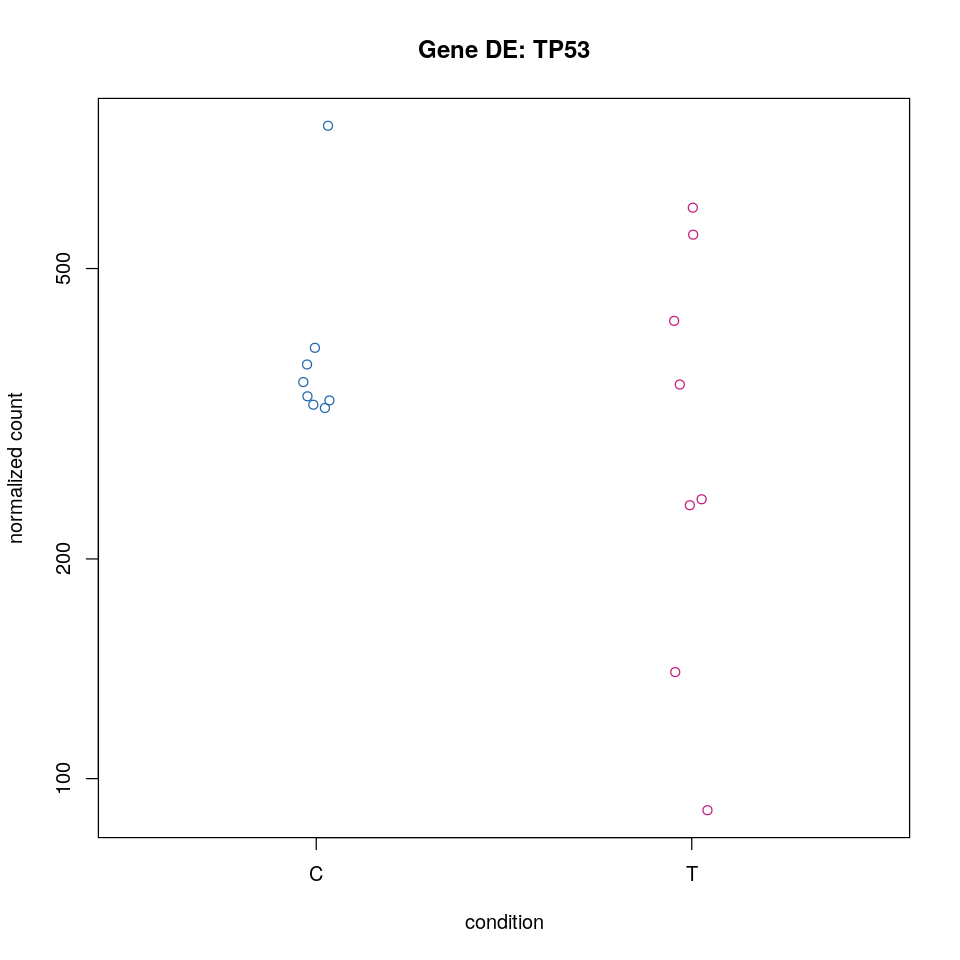

In [119]:
# examine the counts of reads for TP53 across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
plotCounts(dds_rsem_names, 
           gene = "TP53", 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Gene DE: ", "TP53"),
           xlab="condition")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_TP53_counts.png", width=480, height=480))

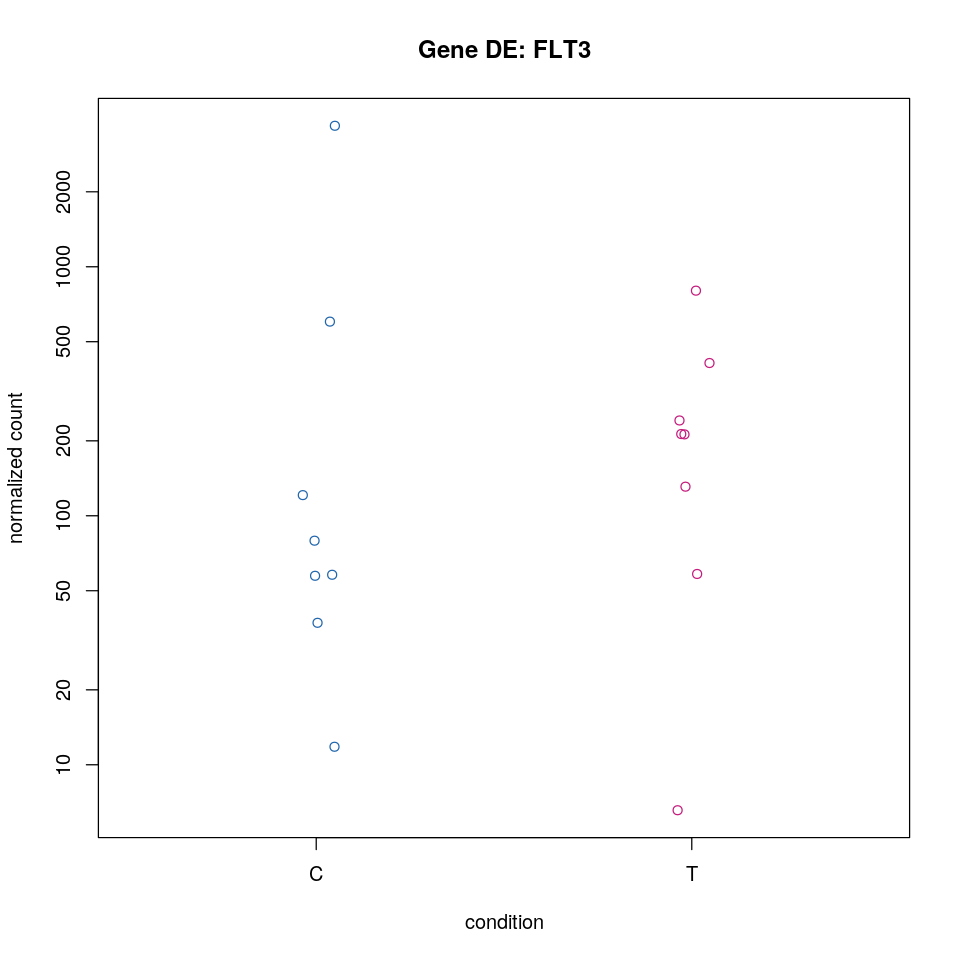

In [120]:
# examine the counts of reads for FLT3 across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
plotCounts(dds_rsem_names, 
           gene = "FLT3", 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Gene DE: ", "FLT3"),
           xlab="condition")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_FLT3_counts.png", width=480, height=480))

In [121]:
# shrink log fold changes association with condition for GENES
# APEGLM = Approximate Posterior Estimation for GLM coefficients
# preserving signal strength while shrinking away noise
resApeglm_genes <- lfcShrink(dds_rsem_names, coef="condition_T_vs_C", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [122]:
# 'coef=2' --> order rather than name
# NORMAL = original DESeq2 shrinkage estimator
resNorm_genes <- lfcShrink(dds_rsem_names, coef=2, type="normal")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [123]:
# ASHR = Adaptive Shrinkage (fitted mixture of normals prior)
resAsh_genes <- lfcShrink(dds_rsem_names, coef=2, type="ashr")

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



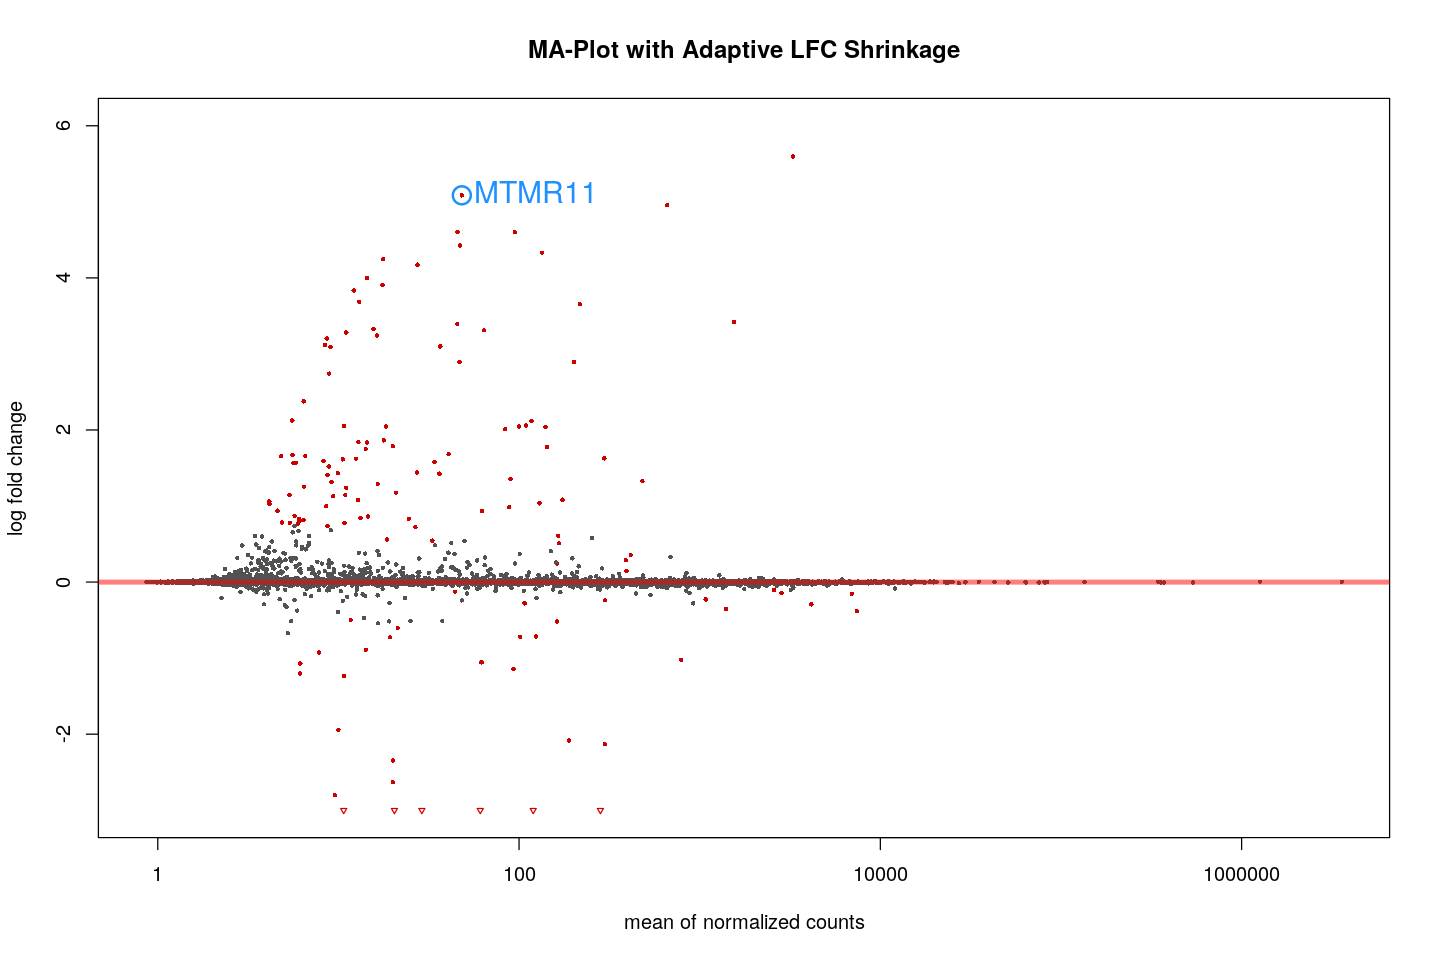

In [134]:
# MA plot
# M (log ratio) and A (mean average)
# scatter plot of log2 fold changes (y-axis) 
# versus the mean of normalized counts (x-axis)
# shows the log2 fold changes attributable to a given variable 
# over the mean of normalized counts for all samples
# --> how different samples are in terms of signal intensities
# + spot the most differentially expressed gene
options(repr.plot.width=12, repr.plot.height=8)
plotMA(resAsh_genes, 
       #xlim=xlim, 
       ylim=c(-3,6), 
       cex=0.5, 
       main="MA-Plot with Adaptive LFC Shrinkage")
with(resAsh_genes[topGene, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topGene, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
invisible(dev.print(png, "DESEQ2_RES/star_rsem_MAplot.png", width=720, height=480))

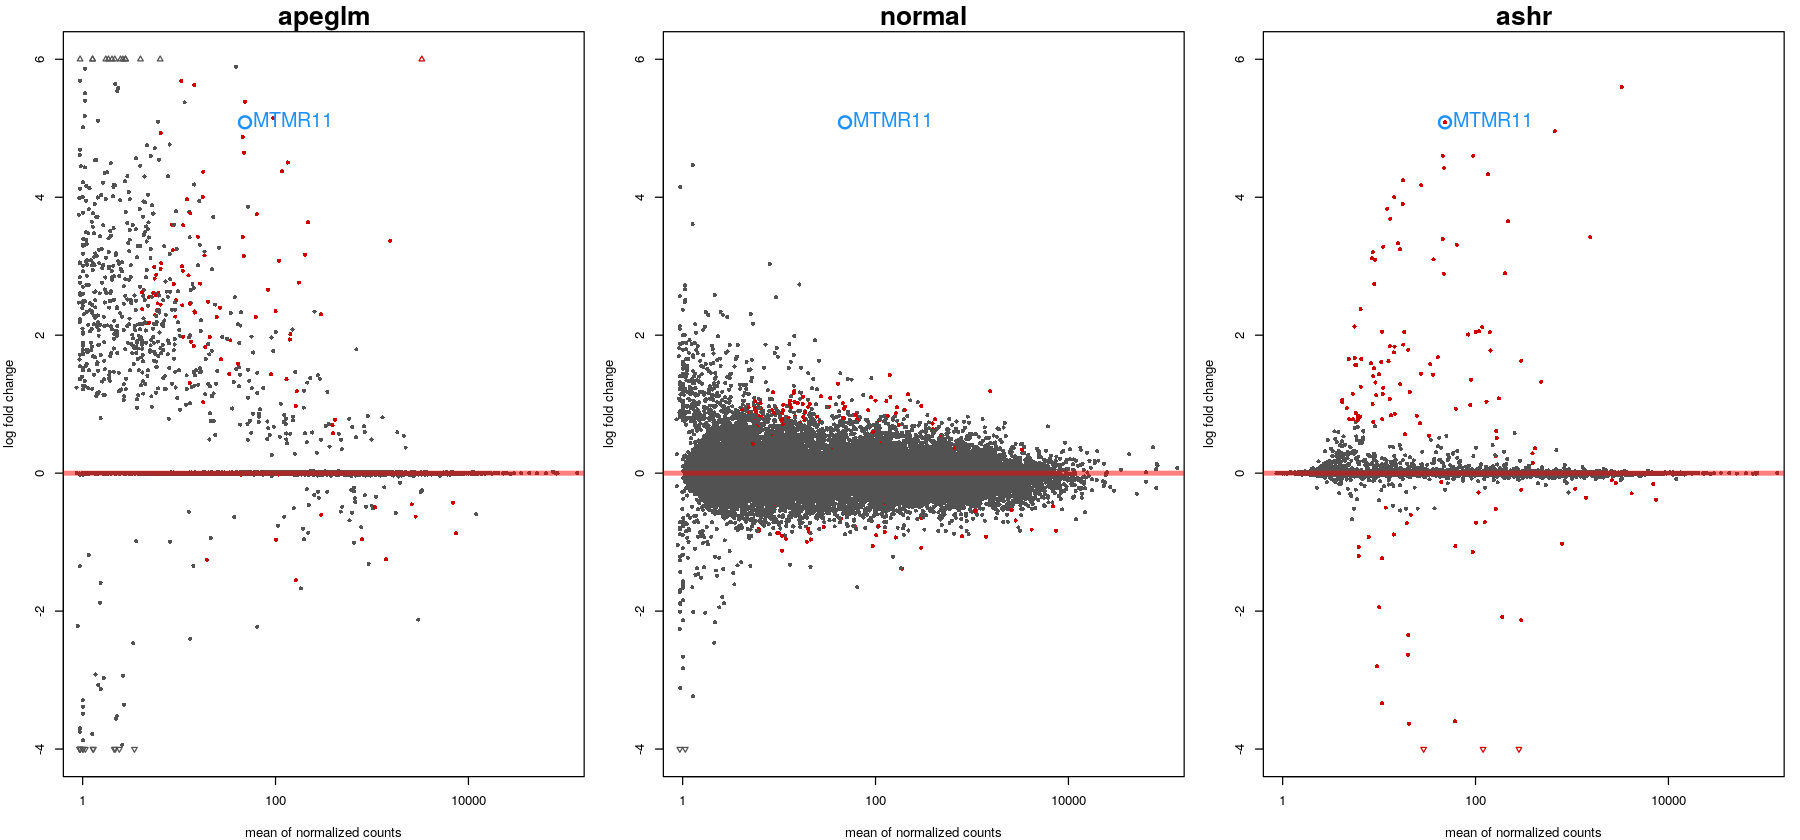

In [135]:
# plot comparison of shrinkage algorithms
options(repr.plot.width=15, repr.plot.height=7)
par(mfrow=c(1,3), mar=c(4,4,2,1))
xlim <- c(1,1e5); ylim <- c(-4,6)
plotMA(resApeglm_genes, xlim=xlim, ylim=ylim, main="apeglm", cex=0.7, cex.main=2)
with(resAsh_genes[topGene, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topGene, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
plotMA(resNorm_genes, xlim=xlim, ylim=ylim, main="normal", cex=0.7, cex.main=2)
with(resNorm_genes[topGene, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topGene, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
plotMA(resAsh_genes, xlim=xlim, ylim=ylim, main="ashr", cex=0.7, cex.main=2)
with(resAsh_genes[topGene, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topGene, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
invisible(dev.print(png, "DESEQ2_RES/star_rsem_shrinkage_algorithms.png", width=920, height=480))

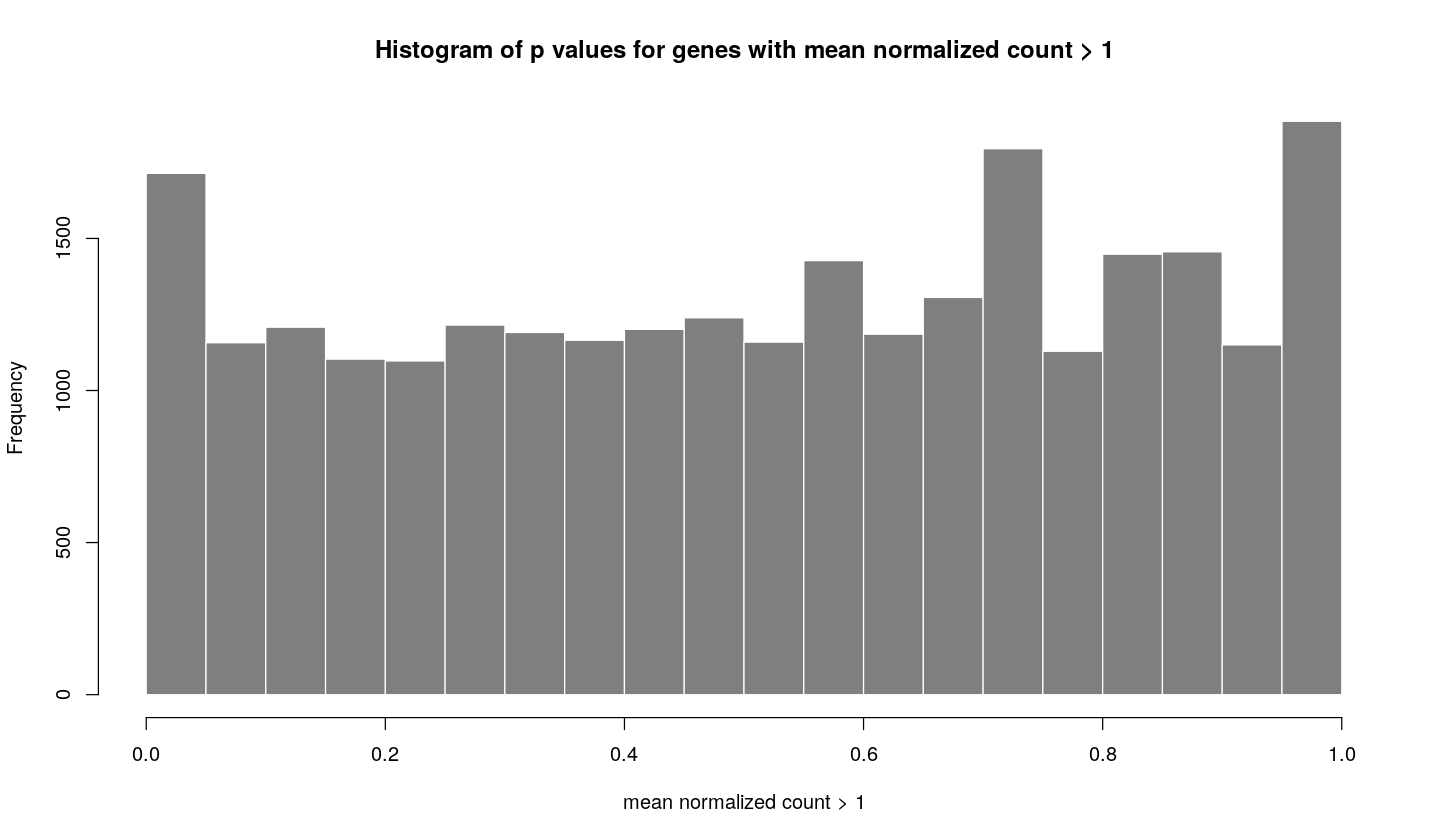

In [136]:
# histogram of the p values
options(repr.plot.width=12, repr.plot.height=7)
hist(res_rsem_names$pvalue[res_rsem_names$baseMean > 1], 
     breaks = 0:20/20, 
     col = "grey50", 
     border = "white",
     main="Histogram of p values for genes with mean normalized count > 1",
     xlab='mean normalized count > 1')
invisible(dev.print(png, "DESEQ2_RES/star_rsem_hist_Pvalues.png", width=720, height=480))

In [137]:
# most DE genes from VST data
head(order(rowVars(assay(vsd)), decreasing = FALSE), 20)

[1]  8014  5609 11574 25220 25260 10305 10806 14155 25363 25359 21821 25552
[13] 23655 25662  4153 25550 16715 19215 25233  6468

In [138]:
rownames(dds_rsem_names)[which.min(res_rsem_names$padj)]

[1] "MTMR11"

In [139]:
rownames(dds_rsem_names)[head(which(res_rsem_names$padj < 0.05),decreasing = FALSE, 20)]

[1] "SCIN"    "TMEM159" "MTMR11"  "FHL1"    "HHAT"    "XYLB"    "TNFSF8" 
 [8] "CNTNAP1" "IL10RA"  "PPFIBP1" "VDR"     "AICDA"   "IL18RAP" "MREG"   
[15] "CDKN2C"  "GNAZ"    "SH3BP4"  "TRPM4"   "TMCC2"   "MICAL2"

In [145]:
# subset of the 20 most highly variable genes from VST data
topVarGenes <- head(which(res_rsem_names$padj < 0.05),decreasing = FALSE, 20)
#topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = FALSE), 20)
mat  <- assay(vsd)[topVarGenes,]
mat  <- mat - rowMeans(mat)
mat

RS01       RS02       RS03        RS04        RS05        RS06        
SCIN    -0.2689839 -0.2710633 -0.25436394 -0.28007965 -0.26167877 -0.260659405
TMEM159  0.8199486  0.1107256  0.19019155  0.92661618  0.03902486  0.506307473
MTMR11  -0.8299007 -0.5452074 -0.35990209 -0.83998439 -0.82380952 -0.822959821
FHL1    -1.0029991 -0.4074830 -0.01271670 -0.37109742 -0.99501414 -1.085845207
HHAT     2.1999939 -0.8895775 -0.85423055  0.01034495 -0.86119704 -0.860278597
XYLB    -0.4227595 -0.2049807 -0.41594580 -0.25686211 -0.03241913 -0.293495202
TNFSF8  -0.3607040 -0.1166843 -0.37276742 -0.37093468 -0.35323552 -0.378220068
CNTNAP1  1.4154083  0.8626291  0.53905344  0.71190660  0.95357674  1.106728554
IL10RA   0.2400100  0.3125356  0.64564680  0.76569575  0.81624045  0.779791016
PPFIBP1 -0.4069060 -0.4600624  0.12329411 -0.35447432 -0.40015563 -0.344300763
VDR     -0.5386943 -0.7167870 -0.91559855  0.19862409 -1.09571398 -0.822879685
AICDA   -0.4355832 -0.4377140 -0.42446109 -0.44726301 -0.42641044 -0.590113944
IL18RAP -0.7036689 -0.3332461 -0.44677604 -0.71369823 -0.28001014 -0.695598822
MREG    -0.6264206 -0.1869224 -0.62566537 -0.55344567 -0.03485561 -0.616576127
CDKN2C  -0.5301080 -0.2645491 -0.09556464 -1.73165069 -0.54509977 -1.474532583
GNAZ    -1.1822419 -1.0863412 -0.27912156 -0.94719302 -0.71045136 -0.390842270
SH3BP4  -0.5235561  2.3906446 -0.50845773 -0.48266197 -0.51595900 -0.514913683
TRPM4   -0.1433148 -1.6032233 -0.97321392 -1.57136129 -1.59677456 -1.555417608
TMCC2   -0.3271986 -0.1229339 -0.31448540 -0.10955388 -0.32094804 -0.008817368
MICAL2  -0.2075094 -0.3433903 -0.24870604 -0.30800502 -0.47395979 -0.256010153
        RS07       RS08         RS09       RS10        RS11        RS12       
SCIN    -0.3216592 -0.447654806 -0.2719534 -0.26340545  1.29653640 -0.25778493
TMEM159  0.4880103  0.272701093 -0.9473740  0.08256512 -0.83753740 -0.18280653
MTMR11  -0.8737595 -0.574374303 -0.2530374 -0.67708473  3.26248593  2.48065365
FHL1    -1.1323743 -0.496329860  2.7108654 -0.68327512 -0.02326459  0.18748511
HHAT    -0.9165623 -0.846798972  3.0357461 -0.40020040  0.06017997 -0.70159209
XYLB    -0.1442377 -0.400991633 -0.2742658  0.08826753  1.71503654  0.28515207
TNFSF8  -0.4113865 -0.286428764 -0.3629942  0.42754996  0.48477163  0.20251474
CNTNAP1  1.0939193  0.660685487 -2.2157013 -1.05055407 -0.84401515 -0.94070928
IL10RA   0.5363171  0.692447091 -0.8100636 -0.45172085 -1.84087993 -0.12397414
PPFIBP1 -0.2221341 -0.210255849 -0.3567139 -0.24460444  0.86958750 -0.20257011
VDR     -0.9268874  0.224848522  0.5596046  1.18706644  0.68301498  0.87006020
AICDA   -0.4950621 -0.413657337  2.3812712  1.66116771 -0.40033851 -0.42133870
IL18RAP -0.7526949 -0.726463517  3.7028140 -0.74083951  1.83380135 -0.69271617
MREG    -0.6907314  0.008646954  0.3506966  1.12811437  2.00387787 -0.73472642
CDKN2C  -1.2339354 -0.168855050 -0.5666329  2.26171388  2.20194934  0.64471335
GNAZ    -0.3711841 -0.748996156  0.6554334  0.52758608  1.18254443  1.62919025
SH3BP4  -0.3669959 -0.287559473  0.4487665 -0.51773912  0.56316081 -0.51190234
TRPM4   -1.6388169 -0.263317041  3.8886219  1.14242812  2.89430828  0.73895721
TMCC2   -0.3731769 -0.371606245  0.1326754 -0.32247626  1.17329596 -0.03999302
MICAL2  -0.3292801 -0.387878195 -0.2694428 -0.47500520  1.45626421 -0.25235124
        RS13        RS14        RS15        RS16       
SCIN     0.73432081 -0.25972963 -0.25463180  1.64279097
TMEM159 -0.44510168 -0.50561930 -0.67740444  0.15975256
MTMR11   1.84997743 -0.80788261 -0.54091964  0.35570510
FHL1     1.82096743 -0.46198748  1.82650105  0.12656782
HHAT     1.98326603 -0.85948367 -0.85461036  0.75500043
XYLB     0.31324643 -0.42094760  0.39879395  0.06640857
TNFSF8   0.70964111 -0.08708075 -0.34652451  1.62248341
CNTNAP1 -1.66048615 -0.47095607 -0.20256964  0.04108415
IL10RA  -1.27539386 -0.91368054  0.29448576  0.33254333
PPFIBP1  2.25814950 -0.39835582 -0.39361591  0.74311810
VDR     -0.03290837  0.36080979 -0.20166612  1.16710683
AICDA    0.0671861

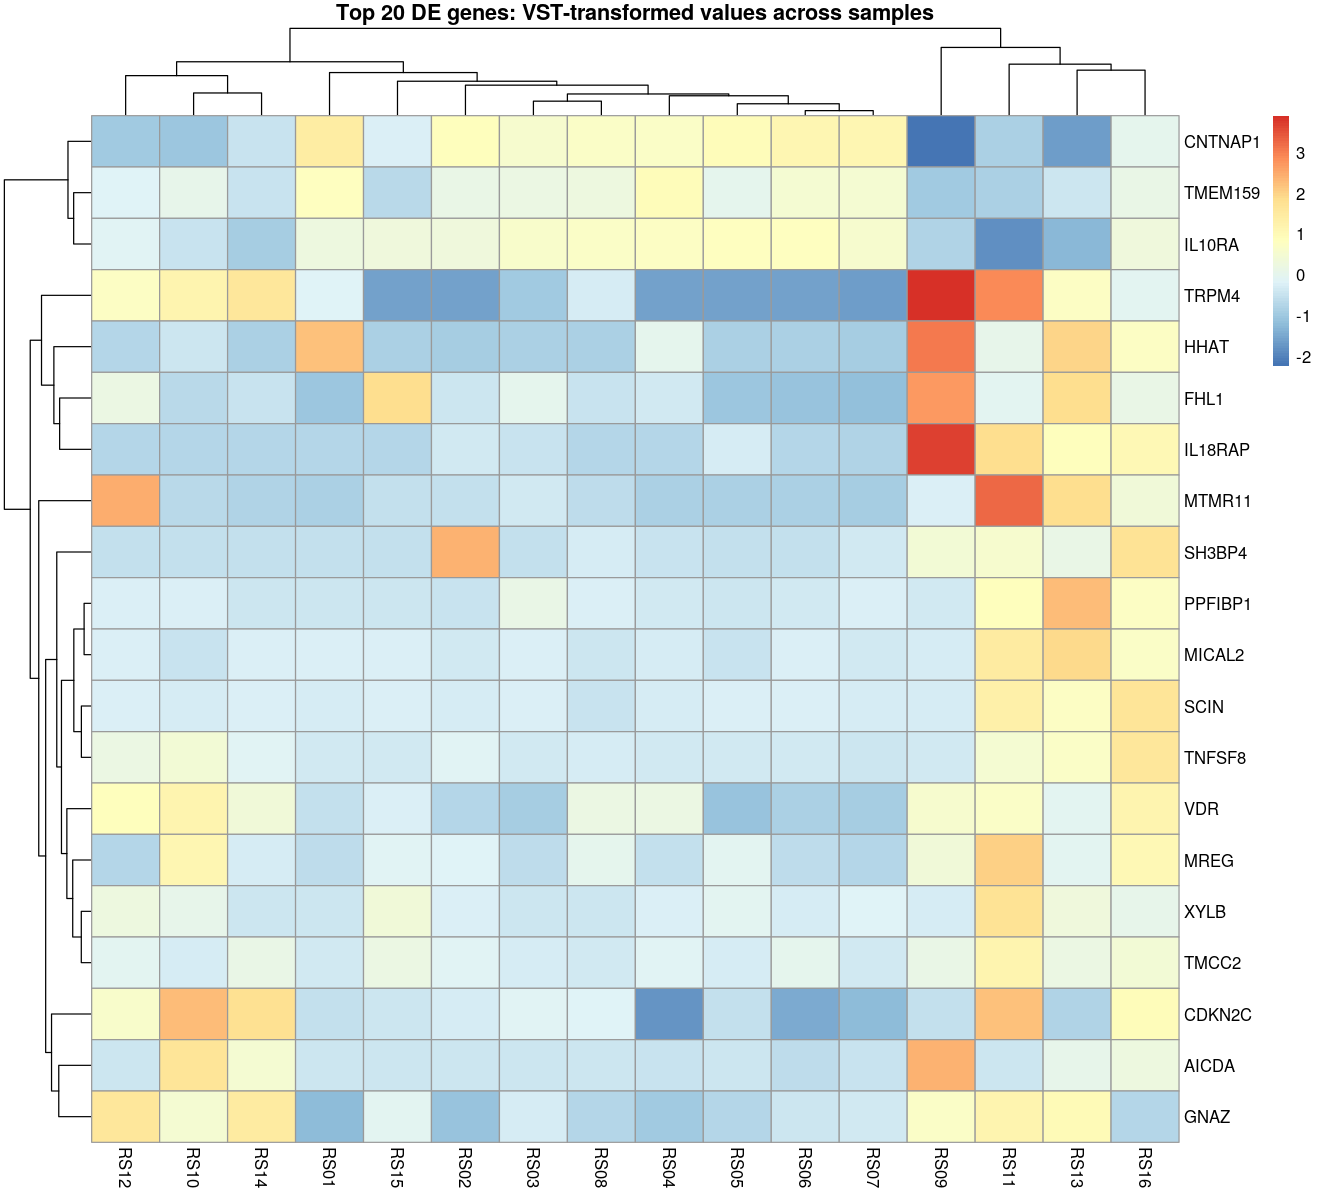

In [146]:
# Heatmap of relative VST-transformed values across samples
# Blocks of genes that covary across patients
# intensity = higher gene expression
options(repr.plot.width=11, repr.plot.height=10)
pm = pheatmap(mat, main="Top 20 DE genes: VST-transformed values across samples")
save_pheatmap_png(pm, "DESEQ2_RES/star_rsem_heatmap_topDEgenes_VST.png")

## Exporting results

#### DESeq2 results

In [148]:
# add add gene_id and gene_name columns, reorder columns
res_rsem_names$gene_id = mcols(dds_rsem_names)$gene_id
res_rsem_names$gene_name = mcols(dds_rsem_names)$gene_name
col_order <- c('gene_id','gene_name', 'baseMean', 
               'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj')
invisible(res_rsem_names <- res_rsem_names[, col_order])
# subset results to chosen adjusted p-value threshold, reorder by increasing padj
res_rsem_names <- subset(res_rsem_names, padj < 0.5)
res_rsem_names <- res_rsem_names[ order(res_rsem_names$padj, decreasing = FALSE), ]
# export DESeq2 processed results sorted by p-values
write.table(res_rsem_names, 
            file = "DESEQ2_RES/DESEQ2_rsem_results.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)

#### APEGLM results

In [149]:
# add add gene_id and gene_name columns, reorder columns
resApeglm_genes$gene_id = mcols(dds_rsem_names)$gene_id
resApeglm_genes$gene_name = mcols(dds_rsem_names)$gene_name
col_order <- c('gene_id','gene_name', 'baseMean', 
               'log2FoldChange', 'lfcSE', 'pvalue', 'padj')
invisible(resApeglm_genes <- resApeglm_genes[, col_order])
# subset results to chosen adjusted p-value threshold, reorder by increasing padj
resApeglm_genes <- subset(resApeglm_genes, padj < 0.5)
resApeglm_genes <- resApeglm_genes[ order(resApeglm_genes$padj, decreasing = FALSE), ]
# export DESeq2 processed results sorted by p-values
write.table(resApeglm_genes, 
            file = "DESEQ2_RES/DESEQ2_rsem_results_APEGLM.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)

#### Reporting with ReportingTools package

In [151]:
# must use the dataset with ACCESSION NUMBERS
des2Report <- HTMLReport(shortName = 'DESEQ2_rsem_ReportingTools',
                         title = 'RNA-seq analysis of differential expression with RSEM & DESeq2',
                         reportDirectory = "DESEQ2_RES")
publish(dds_rsem, 
        des2Report, 
        pvalueCutoff=0.1,
        annotation.db="org.Hs.eg.db",
        make.plots = TRUE,
        factor = colData(dds_rsem)$condition,
        keytype = "ENSEMBL",
        reportDir="DESEQ2_RES")
finish(des2Report)

[1] "DESEQ2_RES/DESEQ2_rsem_ReportingTools.html"

#### Reporting with regionReport package

  |.                                                                     |   2%
   inline R code fragments

  |...                                                                   |   4%
label: docSetup (with options) 
List of 3
 $ bootstrap.show.code   : logi FALSE
 $ dev                   : symbol device
 $ bootstrap.show.message: logi FALSE

  |....                                                                  |   6%
  ordinary text without R code

  |......                                                                |   9%
label: setup (with options) 
List of 1
 $ bootstrap.show.message: logi FALSE

  |.......                                                               |  11%
  ordinary text without R code

  |.........                                                             |  13%
label: PCA
  |..........                                                            |  15%
   inline R code fragments

  |............                                                        

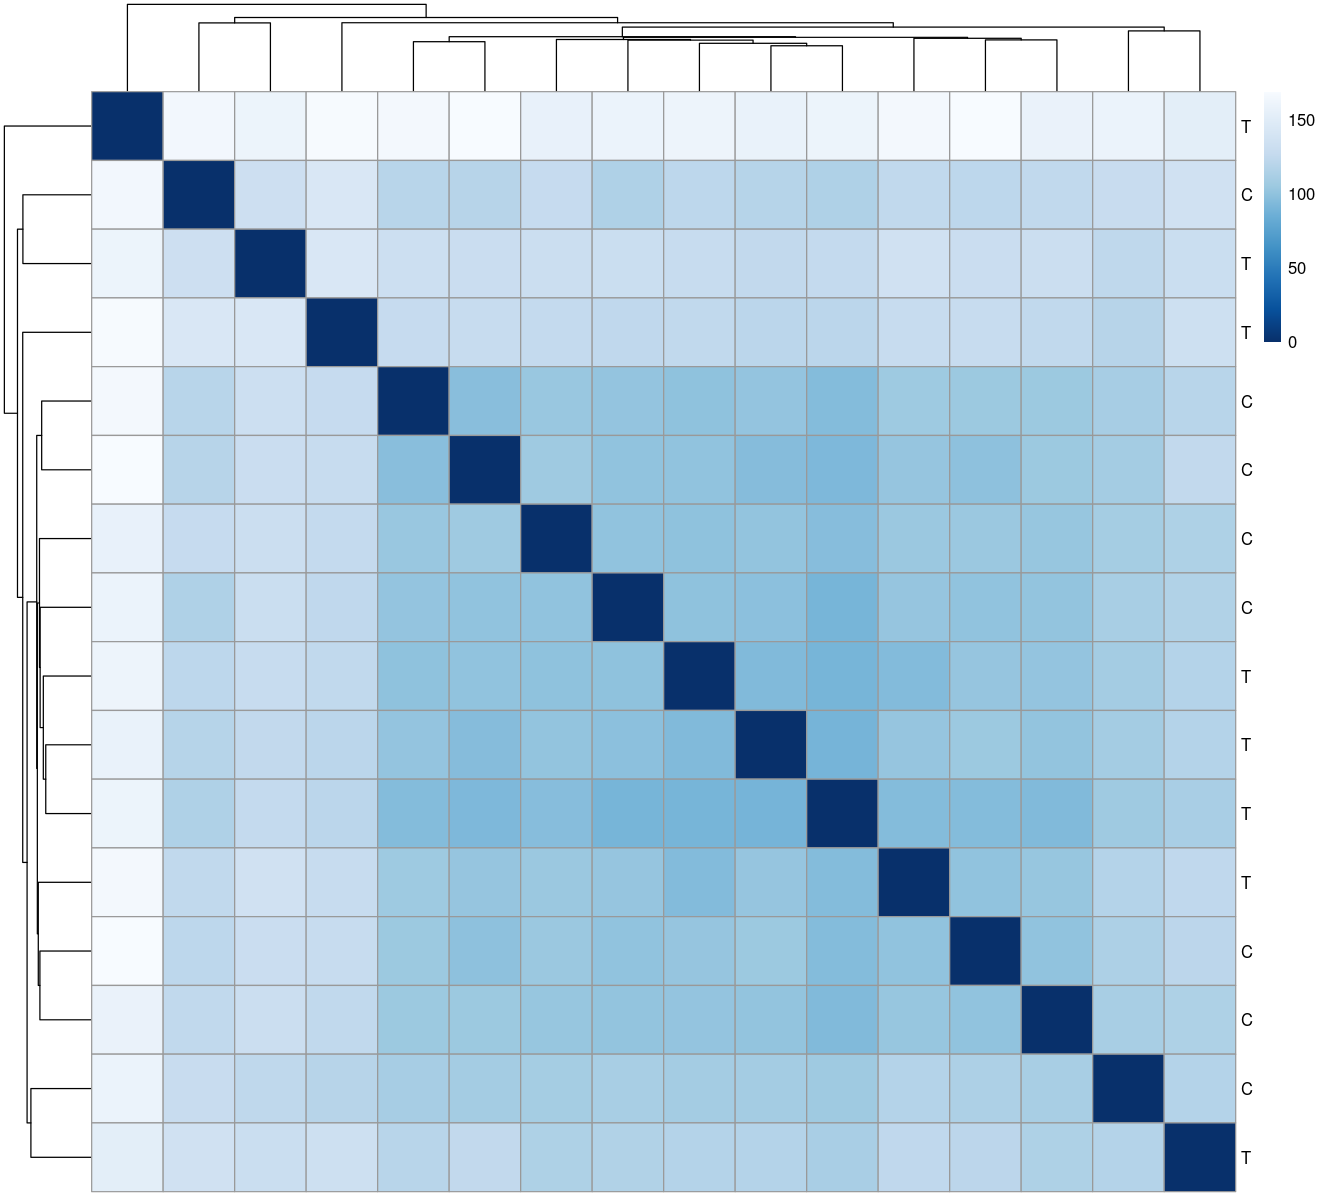

In [152]:
# must use the dataset with genes SYMBOLS
suppressMessages(
reg2report <- DESeq2Report(dds_rsem_names,
                           project = "DESEQ2_rsem_regionReport", 
                           intgroup="condition",
                           outdir = 'DESEQ2_RES',
                           output='DESEQ2_rsem_regionReport',
                           device = "png", 
                           searchURL = "https://www.genecards.org/cgi-bin/carddisp.pl?gene="))

### Karyotype plot 

In [153]:
# retreive significantly differentially expressed genes
# works only with ACCESSION NUMBERS
sig <- res_rsem[which(res_rsem$pvalue < 0.05),]
length(rownames(sig))

[1] 1714

In [154]:
# find chromosomal locations for the genes
keys <- keys(org.Hs.eg.db, keytype = "ENSEMBL")
columns <-c ("CHR", "CHRLOC", "CHRLOCEND")
sel <- AnnotationDbi::select(org.Hs.eg.db, keys, columns, keytype="ENSEMBL")
sel2 <- sel[sel$ENSEMBL %in% rownames(sig),]
sel3 <- na.omit(sel2[!duplicated(sel2$ENSEMBL),])
sel3$strand <- ifelse(sel3$CHRLOC < "*", "-", "+")
sel3$start <- abs(sel3$CHRLOC)
sel3$end <- abs(sel3$CHRLOCEND)

'select()' returned 1:many mapping between keys and columns



In [155]:
# generate a GRanges object that contains the location of the differentially expressed genes
tt <- org.Hs.egCHRLENGTHS
read <- GRanges(seqnames=Rle(paste("chr", sel3$CHR, sep="")),
               ranges=IRanges(start=sel3$start, end=sel3$end),
               strand=Rle(sel3$strand))

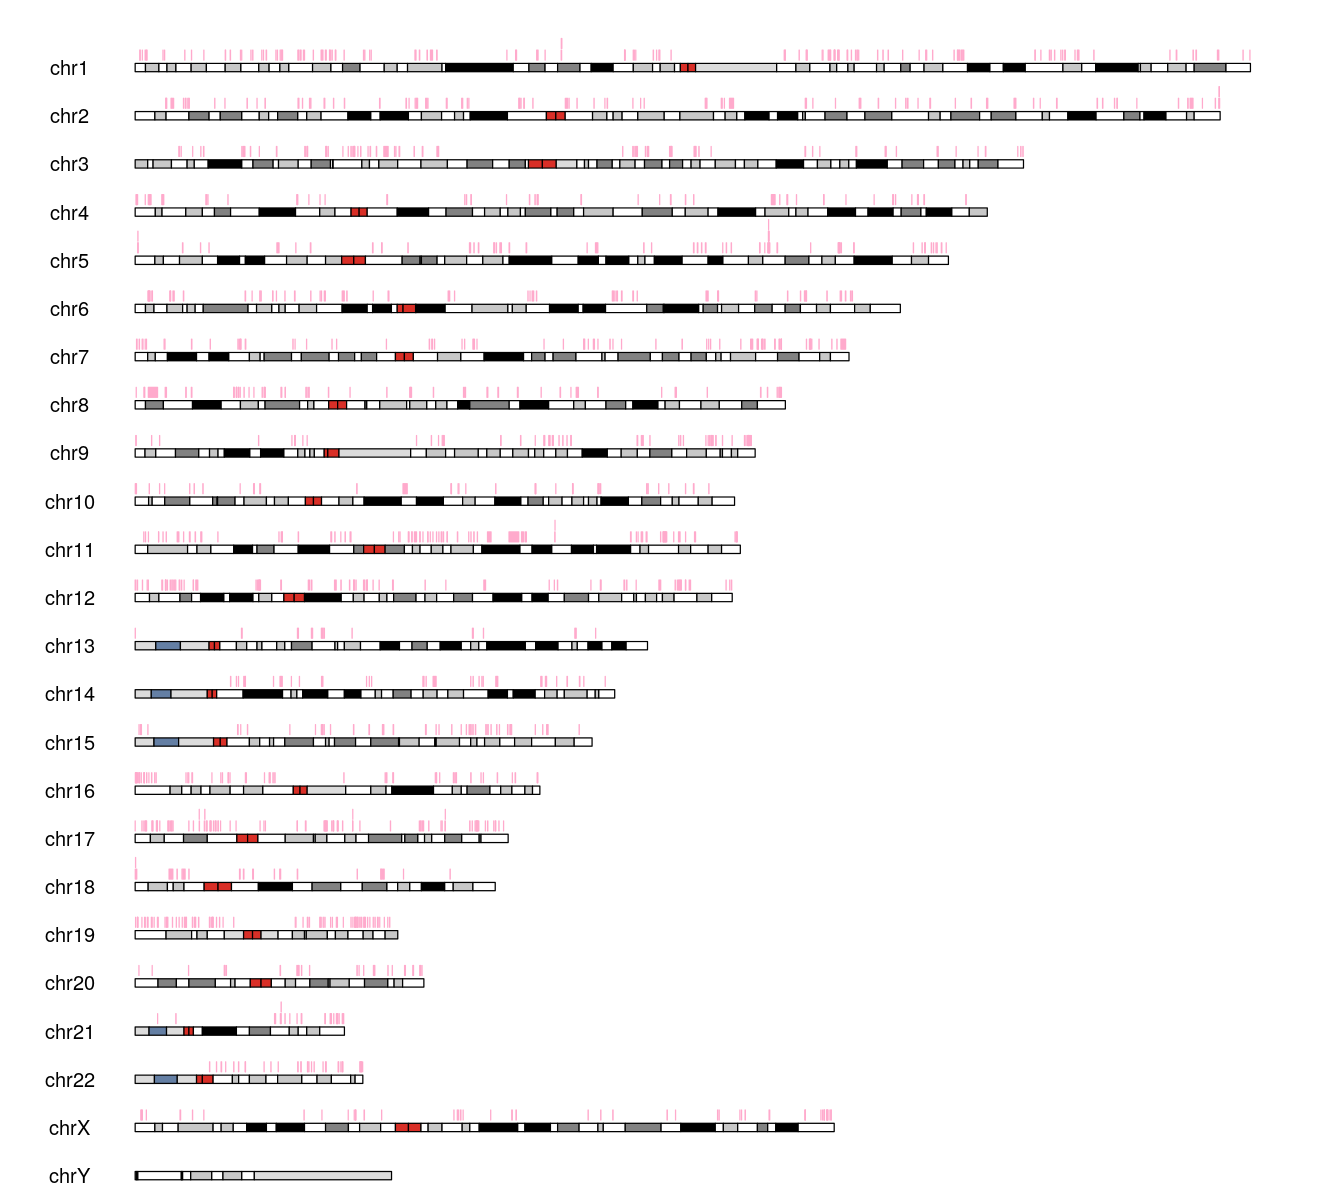

In [156]:
# produce the idiogram using a karyogram-specific layout
kp <- plotKaryotype(genome="hg38")
kpPlotRegions(kp, read, col="#FFAACC")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_karyo_full.png", width=920, height=780))

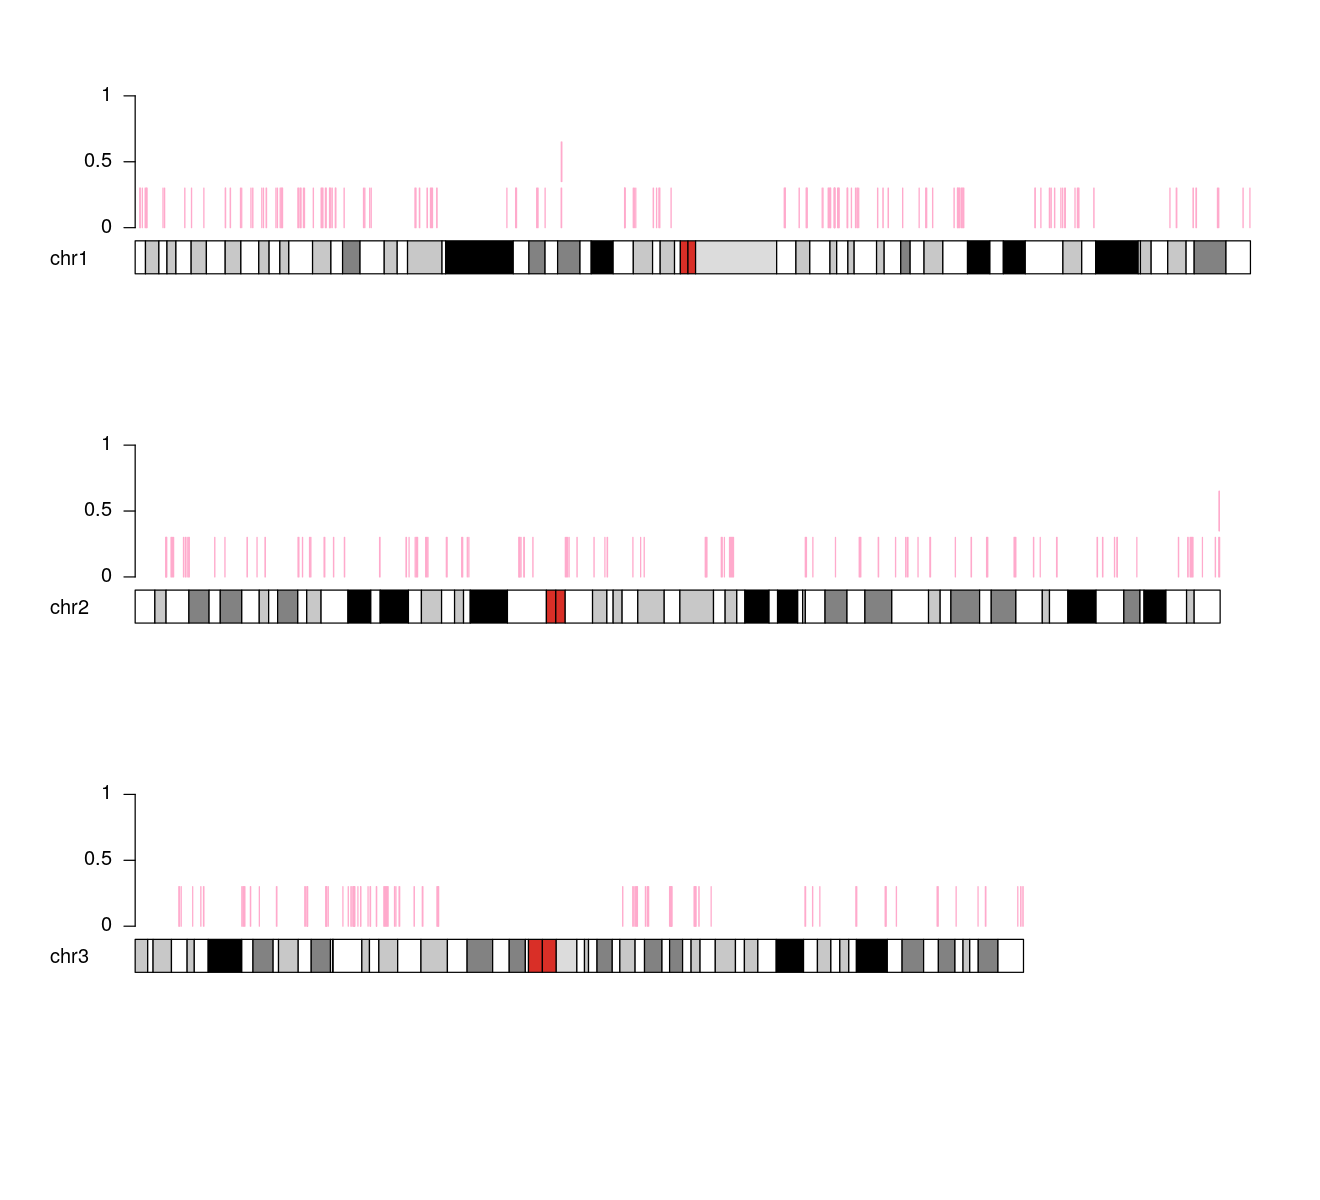

In [157]:
kp <- plotKaryotype(genome="hg38", plot.type=2, chromosomes=c("chr1", "chr2", "chr3"))
kpAxis(kp)
kpPlotRegions(kp, read, col="#FFAACC")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_karyo_select.png", width=920, height=780))

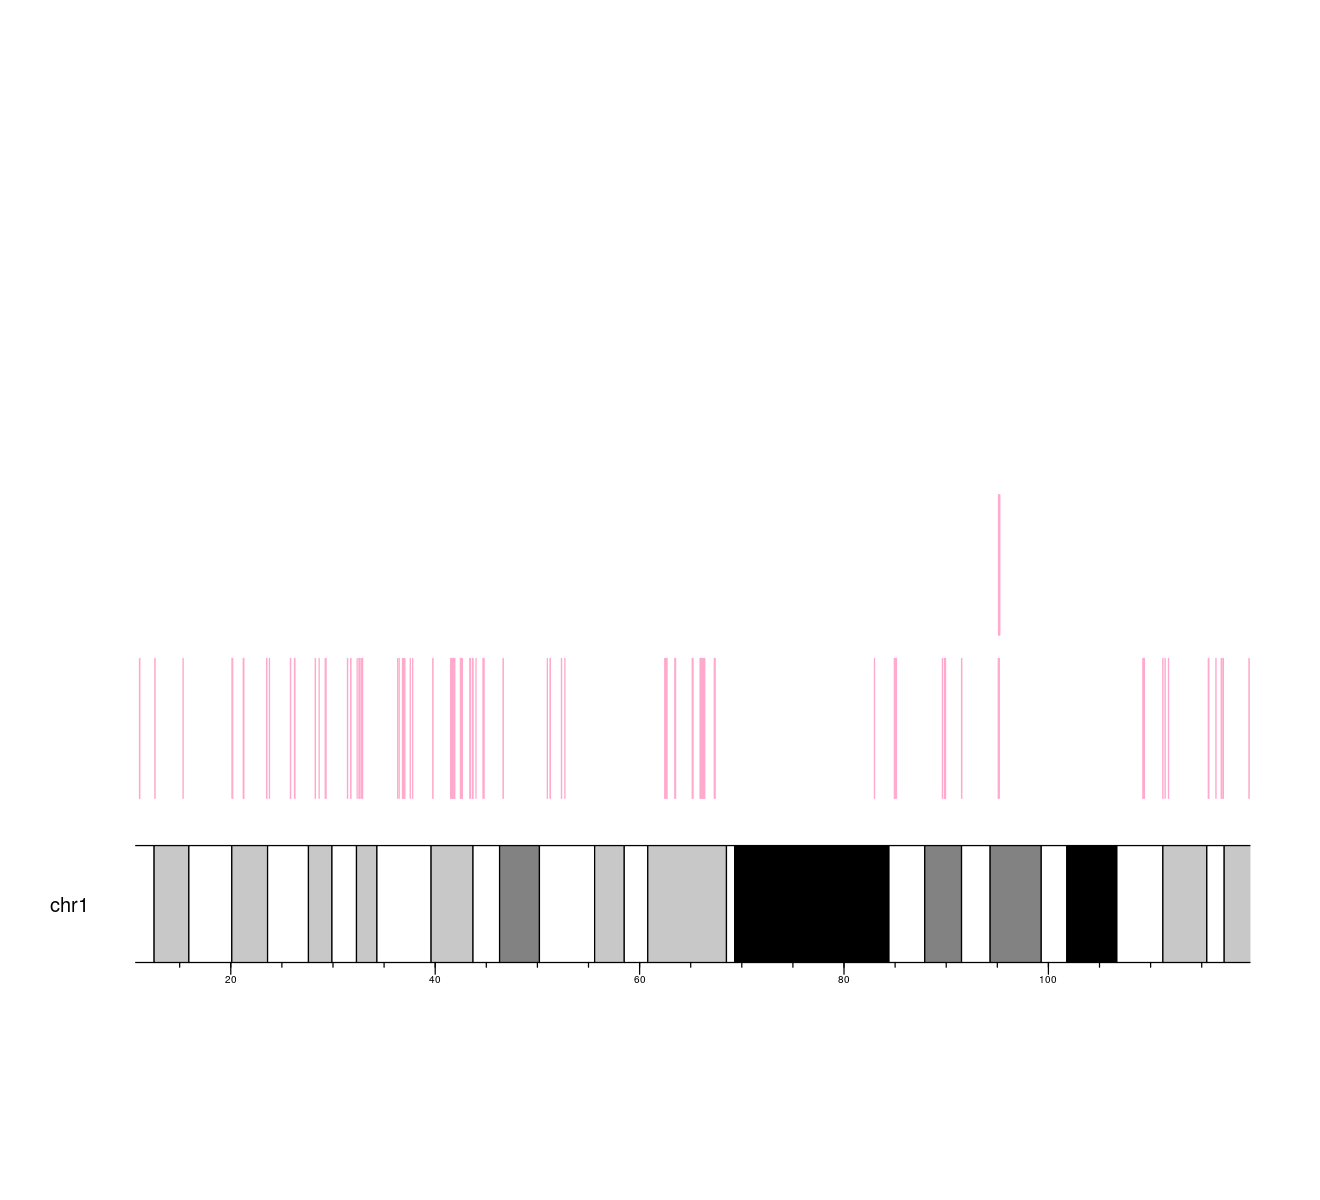

In [158]:
detail.region <- toGRanges(data.frame("chr1", 10644316, 119766509))
kp <- plotKaryotype(genome="hg38", chromosomes = "chr1", zoom=detail.region)
kpAddBaseNumbers(kp)
kpPlotRegions(kp, read, col="#FFAACC")
invisible(dev.print(png, "DESEQ2_RES/star_rsem_karyo_zoom.png", width=920, height=780))

# Limma

In [189]:
GeneMatLimma=read.table("RSEM_RES/rsem_genes_data.matrix")
GeneMatLimma<-data.matrix(GeneMatLimma)
colnames(GeneMatLimma) <- c("RS01","RS02","RS03","RS04","RS05","RS06","RS07","RS08",
                            "RS09","RS10","RS11","RS12","RS13","RS14","RS15","RS16")
# Filter out transcripts with a variance across samples less than one
GeneMatLimma = subset(GeneMatLimma, rowVars(GeneMatLimma) > 1)
condition = c("C","C","C","C","C","C","C","C","T","T","T","T","T","T","T","T")
dge <- DGEList(counts=GeneMatLimma, group=condition)
# remove the decimal
id_list <- rownames(dge)
for (i in 1:length(id_list)) {
  id_list[i] <- vapply(strsplit(id_list[i], ".", fixed = TRUE), "[", "", 1)
}
rownames(dge) <- id_list
# remove duplicates
dge <- dge[!duplicated(rownames(dge)),]
id_list <- rownames(dge)
head(id_list)

[1] "ENSG00000000419" "ENSG00000000457" "ENSG00000000460" "ENSG00000000938" "ENSG00000000971" "ENSG00000001036"

In [167]:
length(rownames(dge))

[1] 22875

In [190]:
# design = table of samples corresponding to conditions
len_condition = 8
condition <- factor(c(rep("C", times=len_condition),c(rep("T", times=len_condition))))
design <- model.matrix(~0+condition)
colnames(design) <- c("C","T")
contrast <- makeContrasts(C,T,T-C, levels = design)

In [191]:
condition

[1] C C C C C C C C T T T T T T T T
Levels: C T

In [192]:
design

C T
1  1 0
2  1 0
3  1 0
4  1 0
5  1 0
6  1 0
7  1 0
8  1 0
9  0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1

In [193]:
contrast

Contrasts
Levels C T T - C
     C 1 0 -1   
     T 0 1  1

In [194]:
# export for Python processing with Pyensembl
id2genes_df <- data.frame("GENE_ID" = id_list, stringsAsFactors = FALSE)
write.table(id2genes_df, 
            file = "RSEM_TEMP/LIMMA_rsem_id2genes.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)

In [195]:
# back from Python
id2genes_df <- read.table(file="RSEM_TEMP/LIMMA_rsem_id2genes_OK.txt", 
                        sep="\t", 
                        header=T, 
                        stringsAsFactors = FALSE)

In [196]:
# check if rownames and dataframe length match
length(id2genes_df$GENE_NAME) == length(rownames(dge))

[1] TRUE

In [197]:
gene_frame = data.frame(gene_id=id2genes_df$GENE_ID, gene_name=id2genes_df$GENE_NAME, stringsAsFactors = FALSE)
dge$genes <- gene_frame

In [198]:
head(dge)

An object of class "DGEList"
$counts
                RS01 RS02 RS03 RS04 RS05 RS06 RS07 RS08 RS09 RS10 RS11 RS12 RS13 RS14 RS15 RS16
ENSG00000000419  195  198  134  283  221  153  254  161  235  230  250  186  135  177  194  206
ENSG00000000457  218  289  241  409  239  228  301  169  395  318  187  173  169  354  220  160
ENSG00000000460  212  177   83  101  156  141  257  144  241  228  194  121  140  237  112   92
ENSG00000000938 2098 3579 1228 2918 4414 2824 3707 2542 5073 1984 1224 1322  892 1930 2862 1899
ENSG00000000971    0    0    1    2    0    0    0    2    0    1    6    1    9    0    0    2
ENSG00000001036  151  159  156   71  172  121  220  128  100  261  163  180   83  156   96  125

$samples
     group lib.size norm.factors
RS01     C 17769697            1
RS02     C 18965472            1
RS03     C 19240540            1
RS04     C 19501207            1
RS05     C 16392959            1
11 more rows ...

$genes
          gene_id gene_name
1 ENSG00000000419      DPM1
2 ENSG00000000457     SCYL3
3 ENSG00000000460  C1orf112
4 ENSG00000000938       FGR
5 ENSG00000000971       CFH
6 ENSG00000001036     FUCA2

### A) Preprocessing

In [153]:
# https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html

In [199]:
# counts are converted to logCPM values using edgeR
# --> damp down the variances of logarithms of low counts
cpm <- cpm(dge, prior.count=5)
lcpm <- cpm(dge, log=TRUE)

In [200]:
# calculate mean and median of library size
L <- mean(dge$samples$lib.size) * 1e-6
M <- median(dge$samples$lib.size) * 1e-6
c(L, M)

[1] 17.65361 16.35917

In [201]:
# before filtering
dim(dge)

[1] 22875    16

In [202]:
# edgeR filtering, keeping as many genes as possible with worthwhile counts
keep <- filterByExpr(dge, group=design)
dge <- dge[keep, keep.lib.sizes=FALSE]
dim(dge)

[1] 11768    16

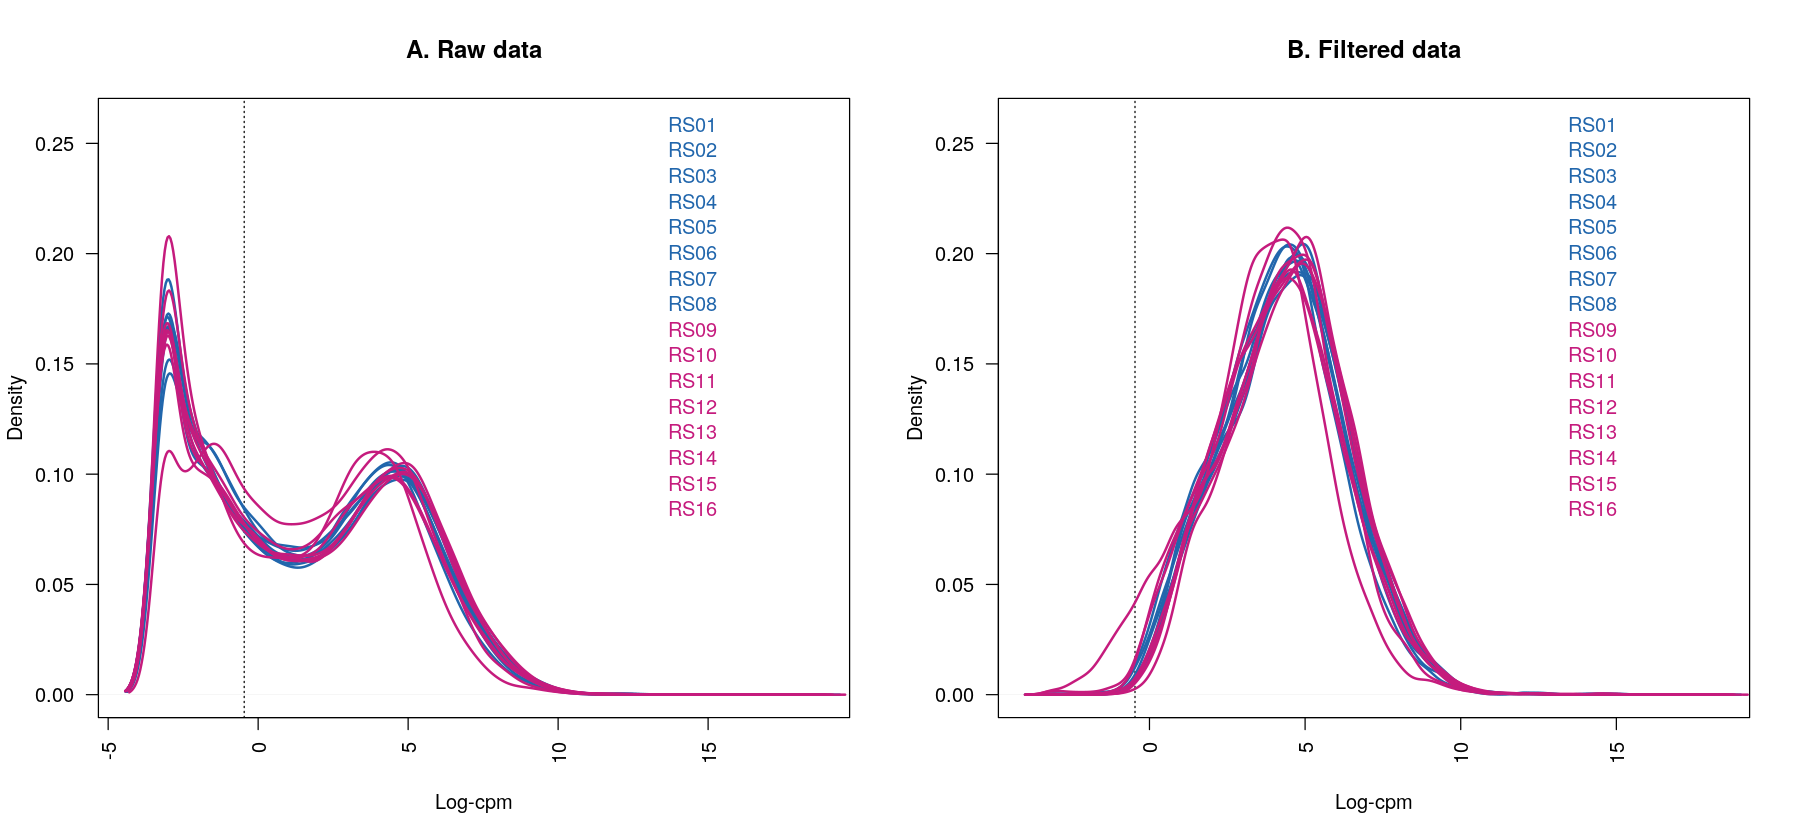

In [203]:
# density of log-CPM values for raw pre-filtered data (A) and post-filtered data (B) 
# Dotted vertical lines mark the log-CPM threshold
options(repr.plot.width=15, repr.plot.height=7)
lcpm.cutoff <- log2(10/M + 2/L)
samplenames <- colnames(dge)
nsamples <- ncol(dge)
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
par(mfrow=c(1,2))

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- cpm(dge, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")
invisible(dev.print(png, "LIMMA_RES/LIMMA_star_rsem_rawVSedgeR.png", width=960, height=480))

In [204]:
# edgeR normalization
# option: "TMM","TMMwsp","RLE","upperquartile","none"
# RLE: relative log expression
# TMM: normalisation by trimmed mean of M-values
# scaling factors closer to 1 --> milder TMM-normalisation effect
dge <- calcNormFactors(dge, method = "TMM")
dge$samples$norm.factors

[1] 1.0310880 0.9783697 0.8442111 1.0716401 1.1134178 1.0893864 1.1307222 0.9883216 0.9120317 1.1844912 0.6032323
[12] 1.1398429 0.8953706 1.2269601 1.1065571 0.8952175

In [205]:
# duplicate dataset and adjust to see differences before/after normalization
dge2 <- dge
dge2$samples$norm.factors <- 1
dge2$counts[,1] <- ceiling(dge2$counts[,1]*0.05)
dge2$counts[,2] <- dge2$counts[,2]*5

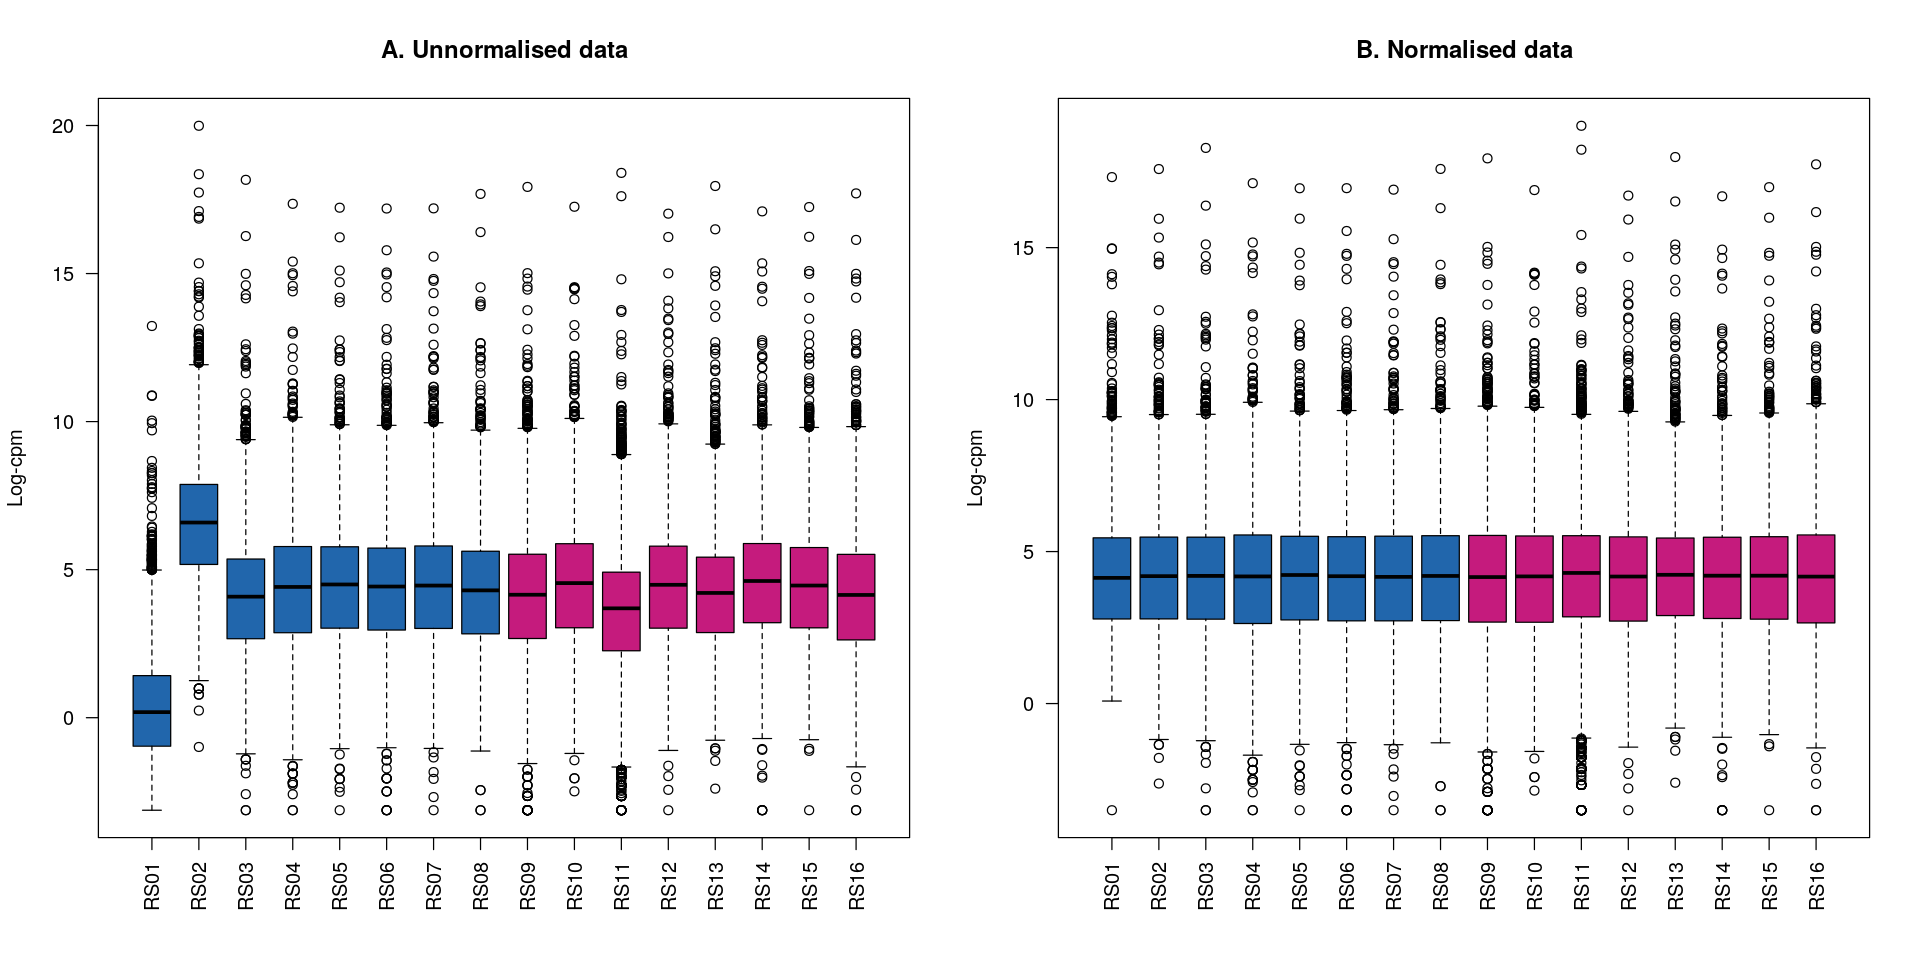

In [206]:
# expression distribution of samples for unnormalised and normalised data
#png("LIMMA_RES/ebseq_FCvsPFC_gene_expr.png")
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(1,2))
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)

lcpm <- cpm(dge2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="A. Unnormalised data",ylab="Log-cpm")

dge2 <- calcNormFactors(dge2)
lcpm <- cpm(dge2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="B. Normalised data",ylab="Log-cpm")

invisible(dev.print(png, "LIMMA_RES/LIMMA_star_rsem_rawVSnorm.png", width=960, height=480))

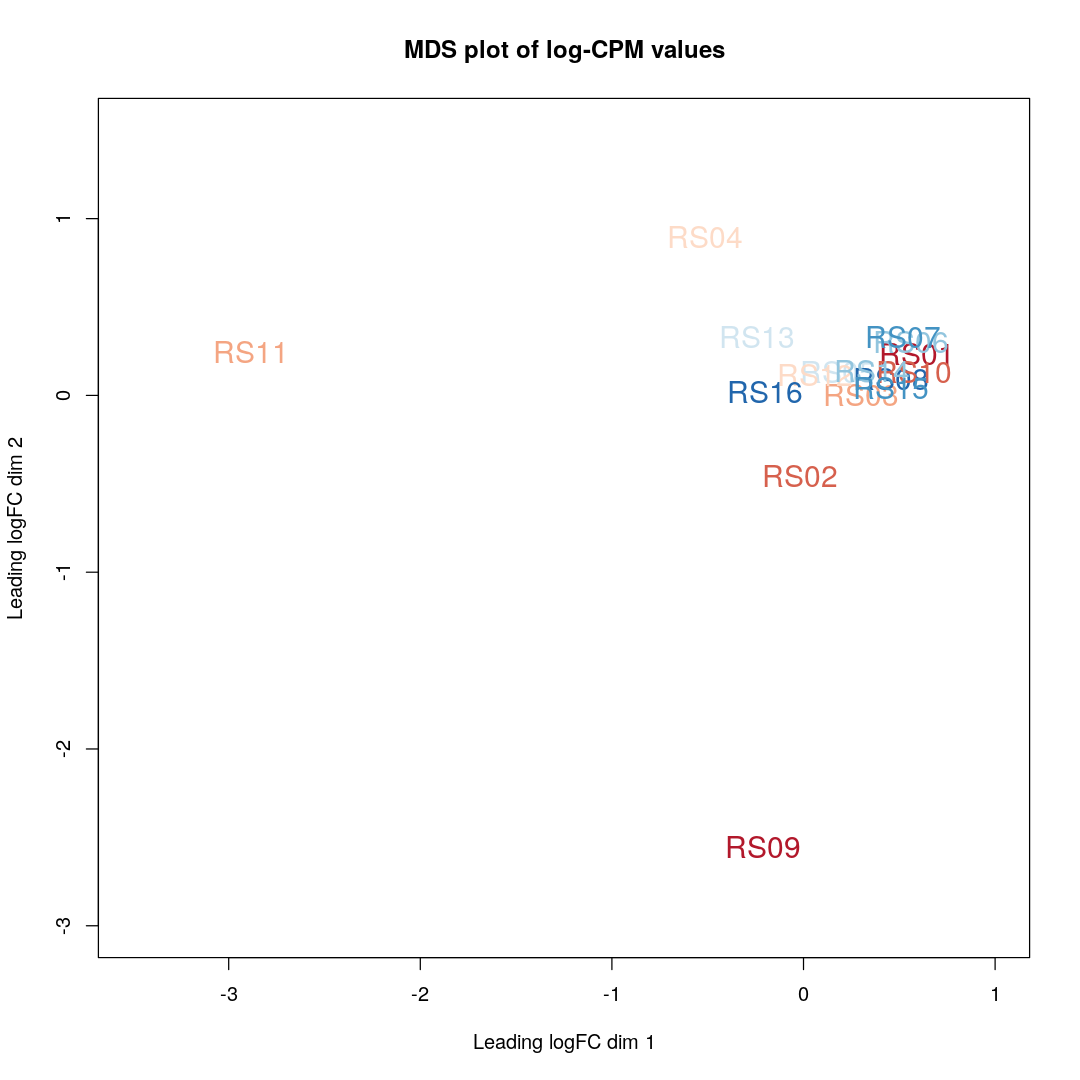

In [207]:
# LogCPM : log counts per million (expression level)
# LogFC : log fold-change (log difference between conditions)
# MDS plot of log-CPM values over dimensions 1 and 2 with samples coloured and labeled by sample
# MDS = multi-dimensional scaling
# dim1 : leading-fold-change that best separates samples and explains the largest proportion of variation in the data
options(repr.plot.width=9, repr.plot.height=9)
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)

lcpm <- cpm(dge, log=TRUE)

col.group <- design
col.group <- as.character(col.group)
plotMDS(lcpm, labels=rownames(dge$samples), col=brewer.pal(n=8, name = "RdBu"), cex=1.5, ylim=c(-3,1.5), xlim=c(-3.5,1))
title(main="MDS plot of log-CPM values")
invisible(dev.print(png, "LIMMA_RES/LIMMA_star_rsem_MDS_log-CPM.png", width=480, height=480))

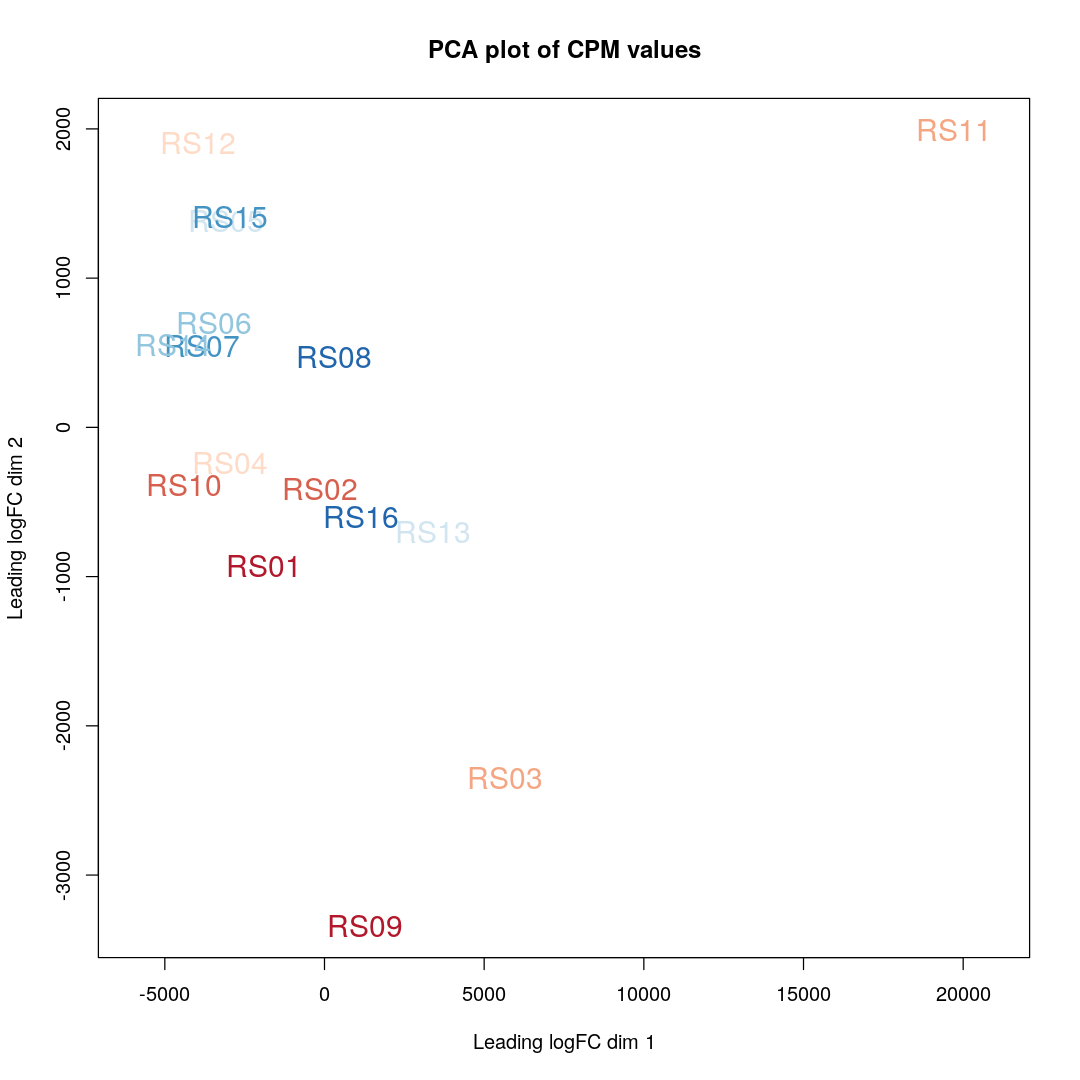

In [208]:
# PCA plot with CPM values over dimensions 1 and 2 with samples coloured and labeled by sample
options(repr.plot.width=9, repr.plot.height=9)
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)

cpm <- cpm(dge)

col.group <- design
col.group <- as.character(col.group)
plotMDS(cpm, 
        labels=rownames(dge$samples), 
        col=brewer.pal(n=8, name = "RdBu"), 
        cex=1.5,
        xlim=c(-6000,21000))
title(main="PCA plot of CPM values")
invisible(dev.print(png, "LIMMA_RES/LIMMA_star_rsem_PCA_CPM.png", width=480, height=480))

## B) Differential Expression Analysis

In [ ]:
# for RNA-seq count data, the variance is not independent of the mean,
# this is true of raw counts or when transformed to log-CPM values
# --> voom converts raw counts to log-CPM values by automatically extracting library sizes 
# and normalisation factors.
# the voom-plot provides a visual check on the level of filtering performed upstream.

#### VOOM transformation

In [515]:
# 1) counts are transformed to log2 counts per million reads (CPM)
# 2) linear model is fitted to the log2 CPM for each gene, residuals are calculated
# 3) smoothed curve is fitted to the sqrt(residual standard deviation) by average expression
# 4) moothed curve is used to obtain weights for each gene and sample
# --> problem if the curve points downward in extremes
# --> should be open "U" shape

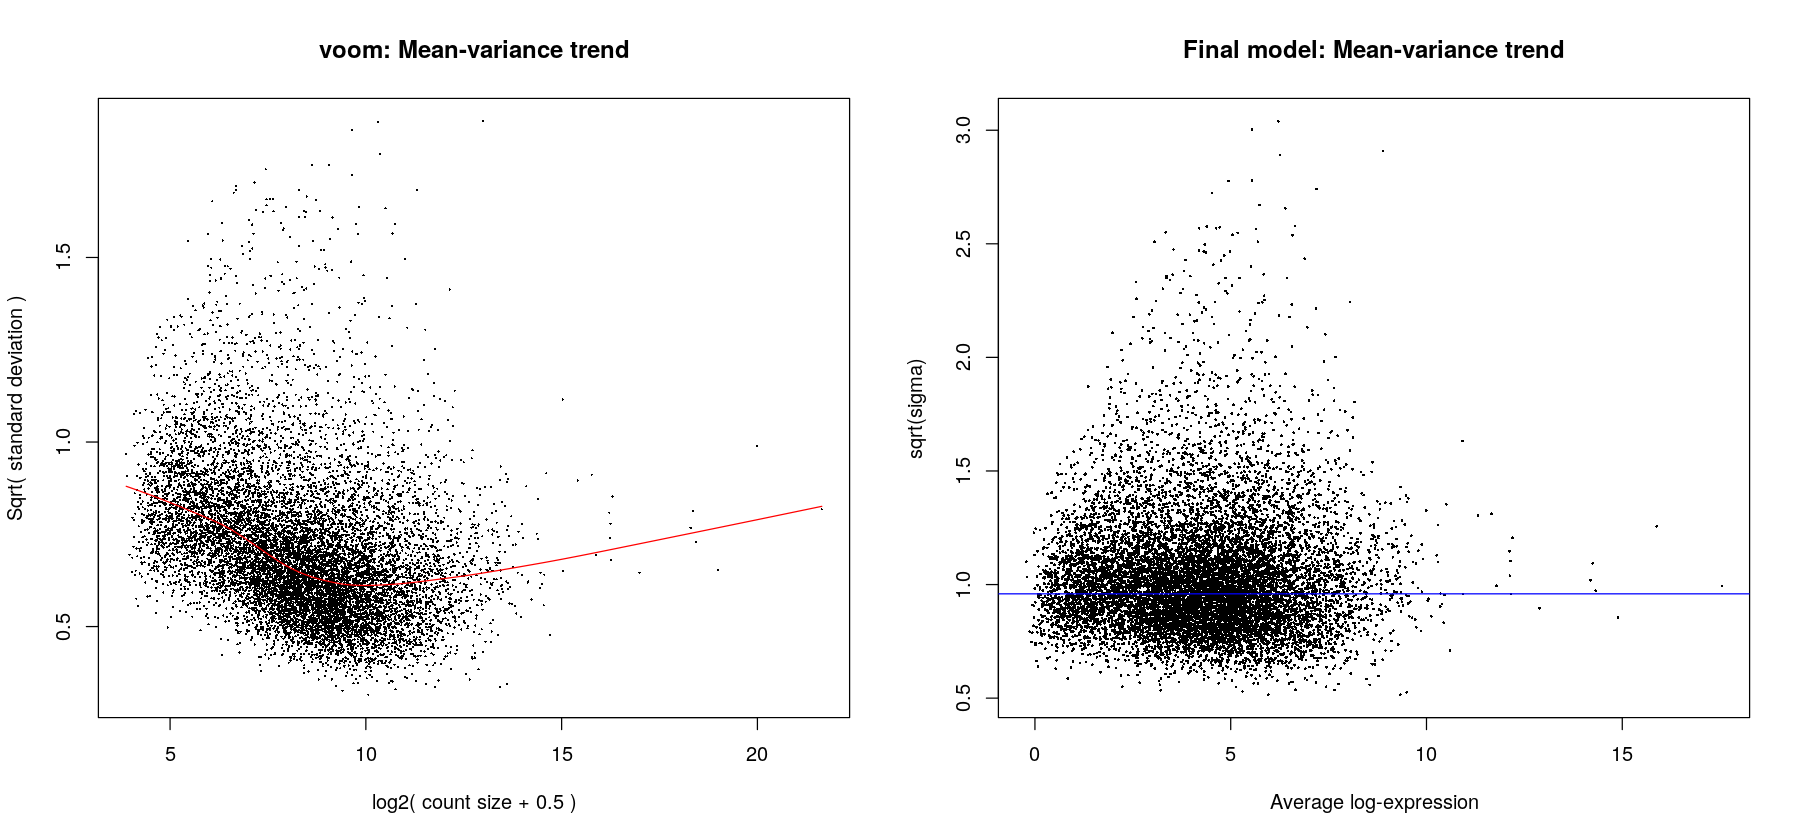

In [209]:
# Means (x-axis) and variances (y-axis) of each gene are plotted to show the dependence
# before voom is applied to the data (left panel) 
# and how the trend is removed after voom precision weights are applied to the data
# LEFT: residual variances from fitting linear models to log-CPM transformed data
# RIGHT: log2 residual standard deviations against mean log-CPM values
options(repr.plot.width=15, repr.plot.height=7)
par(mfrow=c(1,2))
v <- voom(dge, design, plot=TRUE)
# lmFit fits a linear model using weighted least squares for each gene
vfit <- lmFit(v, design)
# contrast between conditions (log fold-changes)
vfit <- contrasts.fit(vfit, contrasts=contrast)
# Empirical Bayes smoothing of standard errors
# shrinks standard errors that are much larger or smaller 
# than those from other genes towards the average standard error
efit <- eBayes(vfit)
plotSA(efit, main="Final model: Mean-variance trend")
invisible(dev.print(png, "LIMMA_RES/LIMMA_star_rsem_voom.png", width=960, height=480))

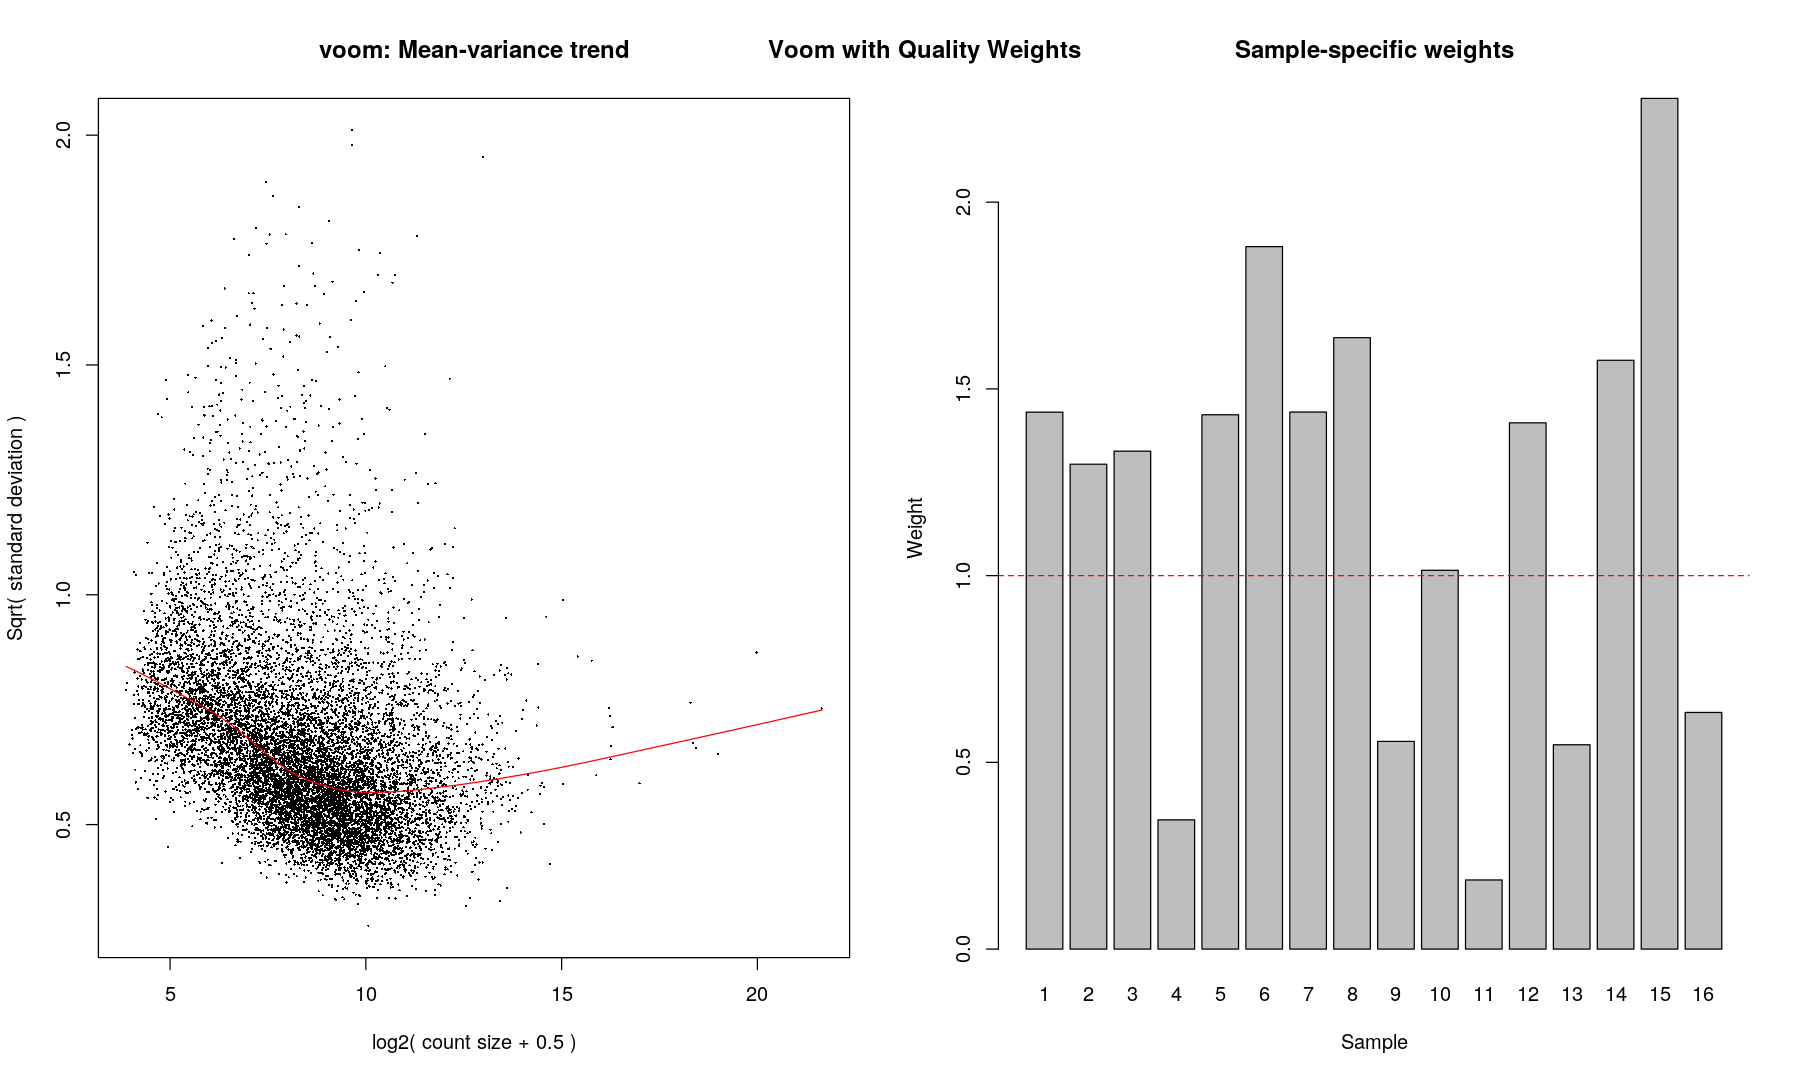

In [210]:
# Voom with Quality weights
options(repr.plot.width=15, repr.plot.height=9)
vv <- voomWithQualityWeights(dge, design, plot = TRUE)
title(main="Voom with Quality Weights")
invisible(dev.print(png, 
                    "LIMMA_RES/LIMMA_rsem_voomQualityWeights.png", 
                    width=960, 
                    height=480))

In [211]:
# After fitting a linear model, the standard errors are moderated 
# using a simple empirical Bayes model
# --> top DE genes
treat_efit <- treat(vfit,lfc=0.1)
top_treat_efit <- topTreat(treat_efit,coef=3, sort.by = "P", n = Inf)
head(top_treat_efit)

gene_id         gene_name  logFC      AveExpr   t         P.Value      adj.P.Val 
ENSG00000279561 ENSG00000279561 AL845472.2  1.7994299 0.9299824  6.209930 4.855970e-06 0.05236888
ENSG00000108797 ENSG00000108797 CNTNAP1    -2.4556703 2.8885629 -5.956682 8.900218e-06 0.05236888
ENSG00000264522 ENSG00000264522 OTUD7B      1.4798915 1.9387908  4.634918 1.316457e-04 0.41686861
ENSG00000165102 ENSG00000165102 HGSNAT     -0.9695086 5.3804322 -4.513527 1.538582e-04 0.41686861
ENSG00000141384 ENSG00000141384 TAF4B       1.0300008 4.4568203  4.424770 1.903387e-04 0.41686861
ENSG00000171121 ENSG00000171121 KCNMB3      1.7934971 1.9860746  4.445684 2.125435e-04 0.41686861

In [212]:
# Export results
write.table(top_treat_efit, 
            file = "LIMMA_RES/LIMMA_rsem_results_topTreat_efit.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)

In [213]:
head(efit$genes$gene_name)

[1] "DPM1"     "SCYL3"    "C1orf112" "FGR"      "FUCA2"    "GCLC"

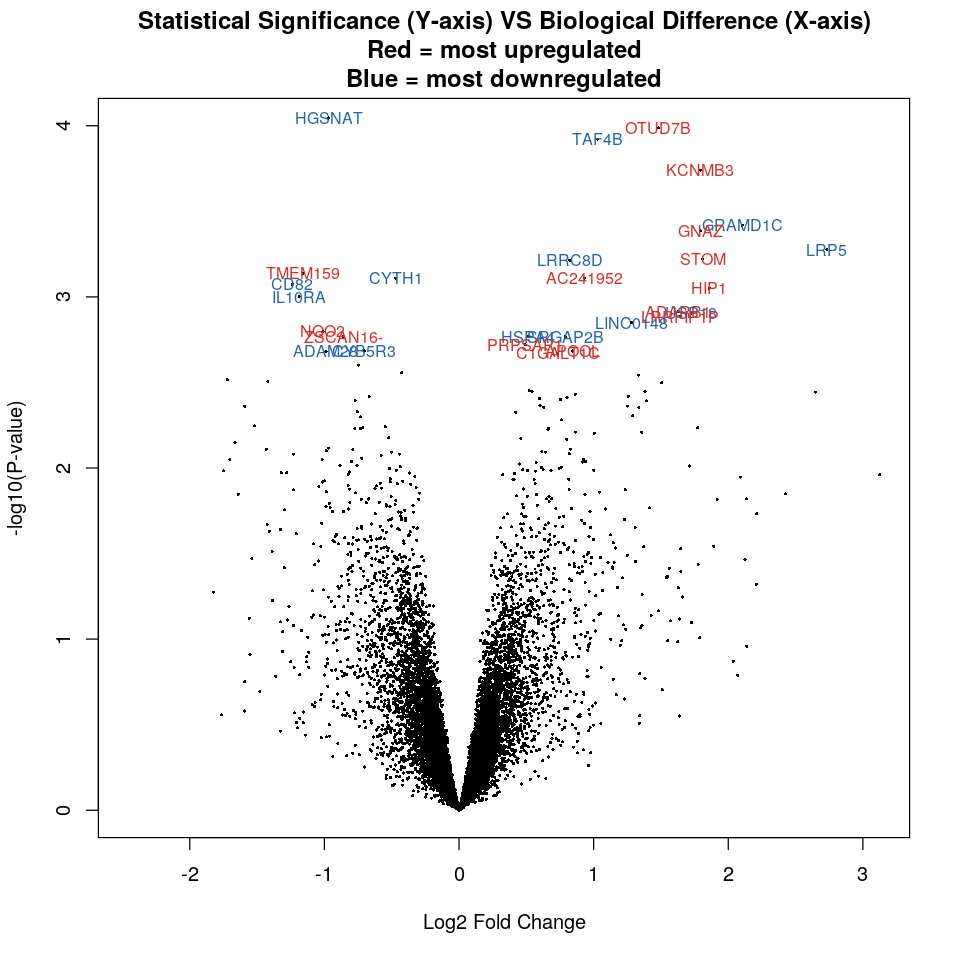

In [214]:
# Volcano plot
# simultaneously assess the P values (statistical significance) 
# and log ratios (biological difference) of differential expression
options(repr.plot.width=8, repr.plot.height=8)
volcanoplot(efit, 
            coef=3, 
            highlight=30, 
            names = efit$genes$gene_name, 
            main = "Statistical Significance (Y-axis) VS Biological Difference (X-axis)\nRed = most upregulated\nBlue = most downregulated",
            hl.col= c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "RdYlBu")[1]),
            ylim=c(0,4))
invisible(dev.print(png, "LIMMA_RES/LIMMA_rsem_volcano.png", width=480, height=480))

In [215]:
# decideTest: classify a series of related t-statistics as up, down or not significant
dt <- decideTests(efit,method="hierarchical",lfc=log2(1.5),adjust.method="fdr")
summary_test <- capture.output(summary(dt[,3]))
fileConn<-file("LIMMA_RES/LIMMA_rsem_resultsSummary_decideTest.txt")
writeLines(summary_test, fileConn)
close(fileConn)
summary(dt[,3])

       T - C
Down     134
NotSig 11477
Up       157

In [223]:
write.fit(efit, 
          dt, 
          file="LIMMA_RES/LIMMA_rsem_results_EFIT.txt", 
          sep="\t", 
          row.names=F)

In [217]:
# top differentially expressed genes
de_genes <- which(dt[,3]!=0)
head(treat_efit$genes$gene_name[de_genes], n=20)

[1] "CD38"     "ACSM3"    "MAP3K14"  "KDM7A"    "CEP68"    "TMEM159"  "ALOX5"    "CD6"      "CCDC28A"  "ATP6V0A1"
[11] "DAPK2"    "ADAM28"   "CTPS2"    "ARAP2"    "WWC3"     "OPN3"     "BCAT1"    "TSPAN32"  "STAG3"    "RAB27A"

In [218]:
# top downregulated genes
down_genes <- which(dt[,3]==-1)
head(treat_efit$genes$gene_name[down_genes], n=20)

[1] "ACSM3"   "MAP3K14" "KDM7A"   "CEP68"   "TMEM159" "ALOX5"   "CD6"     "CCDC28A" "DAPK2"   "ADAM28"  "TSPAN32"
[12] "TULP3"   "ITM2A"   "CD82"    "OVGP1"   "CASS4"   "ABLIM1"  "IZUMO4"  "CYB5R3"  "MYL9"

In [219]:
# top upregulated genes
up_genes <- which(dt[,3]==1)
head(treat_efit$genes$gene_name[up_genes], n=20)

[1] "CD38"     "ATP6V0A1" "CTPS2"    "ARAP2"    "WWC3"     "OPN3"     "BCAT1"    "STAG3"    "RAB27A"   "TCF3"    
[11] "TXK"      "TTC38"    "FMO4"     "MAP2"     "ULK2"     "CEP128"   "NFKBIA"   "FAM83D"   "VWA8"     "STK3"

In [220]:
# top DE genes
# AveExpr: Average expression across all samples, in log2 CPM
# F: logFC divided by its standard error
# P.Value: Raw p-value (based on F) from test that logFC differs from 0
# adj.P.Val: Benjamini-Hochberg false discovery rate adjusted p-value
# --> Gene X has different expression in C and T...
# --> topTable generates a table of differentially expressed probesets
table_efit <- topTable(efit, coef=3, sort.by = "P", n = Inf)
head(table_efit, 20)

gene_id         gene_name  logFC      AveExpr   t         P.Value      adj.P.Val  B         
ENSG00000279561 ENSG00000279561 AL845472.2  1.7994299 0.9299824  6.575342 3.803047e-06 0.04475426 -1.9095794
ENSG00000108797 ENSG00000108797 CNTNAP1    -2.4556703 2.8885629 -6.209548 7.837478e-06 0.04611572 -1.0433216
ENSG00000165102 ENSG00000165102 HGSNAT     -0.9695086 5.3804322 -5.032617 9.014657e-05 0.28182827 -0.4769667
ENSG00000264522 ENSG00000264522 OTUD7B      1.4798915 1.9387908  4.970808 1.029354e-04 0.28182827 -2.1533776
ENSG00000141384 ENSG00000141384 TAF4B       1.0300008 4.4568203  4.900551 1.197435e-04 0.28182827 -0.8306864
ENSG00000171121 ENSG00000171121 KCNMB3      1.7934971 1.9860746  4.708200 1.815951e-04 0.35616844 -2.2737433
ENSG00000178075 ENSG00000178075 GRAMD1C     2.1033850 2.1422442  4.368847 3.813145e-04 0.60560548 -2.4101323
ENSG00000128266 ENSG00000128266 GNAZ        1.7950652 2.5192767  4.333975 4.116965e-04 0.60560548 -2.2883967
ENSG00000162337 ENSG00000162337 LRP5        2.7325782 2.1574462  4.220337 5.287670e-04 0.65292393 -2.4973985
ENSG00000148175 ENSG00000148175 STOM        1.8094256 2.5783342  4.161488 6.020771e-04 0.65292393 -2.3852191
ENSG00000171492 ENSG00000171492 LRRC8D      0.8229789 5.5114244  4.155333 6.103130e-04 0.65292393 -1.3705718
ENSG00000011638 ENSG00000011638 TMEM159    -1.1586507 2.3780183 -4.076455 7.264877e-04 0.65366208 -2.5215164
ENSG00000108669 ENSG00000108669 CYTH1      -0.4693496 8.6206329 -4.045960 7.771566e-04 0.65366208 -1.6879736
ENSG00000275131 ENSG00000275131 AC241952.1  0.9318909 4.3953751  4.045678 7.776401e-04 0.65366208 -1.6983974
ENSG00000085117 ENSG00000085117 CD82       -1.2392747 4.6446864 -4.009411 8.425866e-04 0.65398911 -1.7197258
ENSG00000127946 ENSG00000127946 HIP1        1.8585401 3.0304295  3.985085 8.891762e-04 0.65398911 -2.3495804
ENSG00000110324 ENSG00000110324 IL10RA     -1.1877826 8.5681738 -3.932963 9.978964e-04 0.69077911 -1.8080708
ENSG00000197381 ENSG00000197381 ADARB1      1.6285521 4.0995136  3.841183 1.222747e-03 0.76615480 -2.0665216
ENSG00000184979 ENSG00000184979 USP18       1.7266290 1.1032655  3.832627 1.246136e-03 0.76615480 -3.0374109
ENSG00000240429 ENSG00000240429 LRRFIP1P1   1.6437050 2.5104919  3.812788 1.302099e-03 0.76615480 -2.6624559

In [221]:
# how many DE genes with P.Val < 0.1
length(which(table_efit$P.Val < 0.1))

[1] 1188

In [222]:
write.table(table_efit, 
          file="LIMMA_RES/LIMMA_rsem_results_topTable_efit.txt", 
          sep="\t", 
          row.names=F)

In [224]:
# adding the status to genes
efit$genes$Status <- dt[,3]

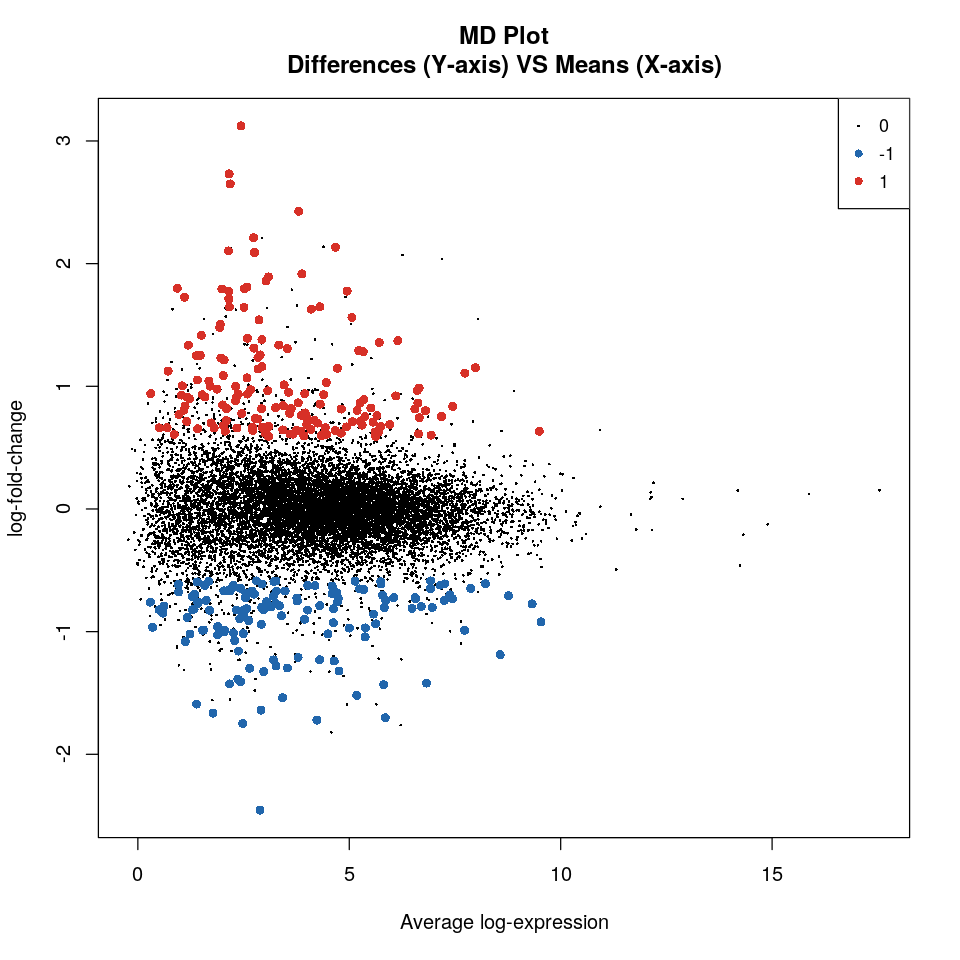

In [225]:
# Mean-difference plot
# log fold changes (differences) versus average log values (means)
options(repr.plot.width=8, repr.plot.height=8)
plotMD(efit,coef=3, 
       status=efit$genes$Status,
       main="MD Plot\nDifferences (Y-axis) VS Means (X-axis)", 
       hl.col= c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "RdYlBu")[1]),
        values=c(-1,1))
invisible(dev.print(png, "LIMMA_RES/LIMMA_rsem_MD_plot.png", width=480, height=480))

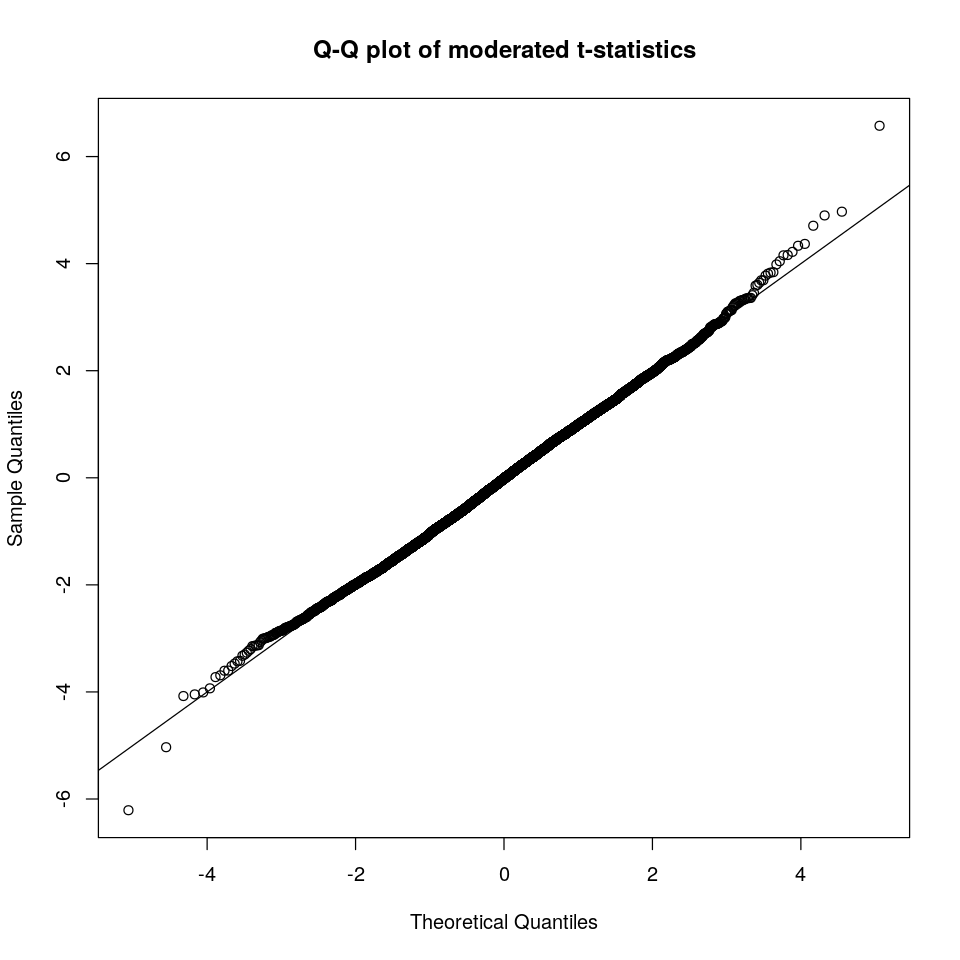

In [226]:
# Q-Q plot of moderated t-statistics
# Plots the quantiles of a data sample against 
# the theoretical quantiles of a Student's t distribution
qqt(efit$t[,3],df=efit$df.residual+efit$df.prior, main ="Q-Q plot of moderated t-statistics")
abline(0,1)
invisible(dev.print(png, "LIMMA_RES/LIMMA_rsem_QQ_plot.png", width=480, height=480))